In [ ]:
# Ran with predictors_simple kernel
# Python 3.10.8

import numpy as np # 1.26.4
import pandas as pd # 2.2.3
import tensorflow as tf # 2.10.0
import matplotlib # 3.10.3
import torch # 2.0.0

matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from matplotlib import pyplot as plt
from joblib import load
from scipy.stats import spearmanr, pearsonr, mannwhitneyu
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.metrics import auc
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
import seaborn as sns

import os

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction/Model")
from ADModel_abund import ADModel_abund
from Data import DataReader, SplitData, FastTensorDataLoader, one_hot_encode

os.chdir("/Users/claireleblanc/Documents/tools_software/adhunter")
from actpred.models import ActCNNSystem

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

os.chdir("/Users/claireleblanc/Documents/grad_school/staller_lab/NN_interpretability_for_AD_prediction")

In [ ]:
# Parameters to make figures work better with illustrator 
import matplotlib 
# For higher resoltion figures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['pdf.fonttype'] = 42

In [ ]:
# Reading in the full length sequences and tile data

data = pd.read_csv("Data/Unique_502_Gcn4_Seqs_three_clusters.csv", index_col=0)
test_seqs= data[data["heirarchical"] == 1]
val_seqs= data[data["heirarchical"] == 2]
train_seqs = data[data["heirarchical"] == 3]

tile_data = pd.read_csv("Data/pm_gcn4_sort2_pools_allchannels_wrangled.csv")

activity_dict = {}
for i in tile_data.index:
    activity_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"activity"]

abund_dict = {}
for i in tile_data.index:
    abund_dict[tile_data.loc[i,"aa_seq"]] = tile_data.loc[i,"abundance"]

used_tiles = []

def get_tile_activity(tile):
    used_tiles.append(tile)
    return activity_dict.get(tile)

def get_tile_abundance(tile):
    return abund_dict.get(tile)


# Break full length seqs into tiles, adding in the final tile
test_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in test_seqs["Sequence"]]
test_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in test_seqs["Sequence"]]
test_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in test_seqs["40_tiles"]]
test_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in test_seqs["40_tiles"]]

val_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in val_seqs["Sequence"]]
val_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in val_seqs["Sequence"]]
val_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]
val_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in val_seqs["40_tiles"]]


train_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in train_seqs["Sequence"]]
train_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in train_seqs["Sequence"]]
train_seqs["40_tiles_exp_activities"] = [[get_tile_activity(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]
train_seqs["40_tiles_exp_abundance"] = [[get_tile_abundance(tile) for tile in tiles] for tiles in train_seqs["40_tiles"]]

unused_tiles = list(set(tile_data["aa_seq"]).difference(set(used_tiles)))
other_tiles = pd.DataFrame(unused_tiles, columns=["aa_seq"])
other_tiles["activity"] = [get_tile_activity(s) for s in other_tiles["aa_seq"]]
other_tiles["abundance"] = [get_tile_abundance(s) for s in other_tiles["aa_seq"]]


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_31331/2842297121.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["40_tiles"] = [[seq[i:i+40] for i in range(0,len(seq)-39,5)] + [seq[-40:]] for seq in test_seqs["Sequence"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_31331/2842297121.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["40_tile_centers"] = [[i+20 for i in range(0,len(seq)-39,5)] + [len(seq)-20] for seq in test_seqs["Sequence"]]
/var/folders/3

In [ ]:
# This is an attempt to choose the "best" model in an unbiased way
# Specifically, it tries to choose a model that has both a high pearson and a high spearman correlation
# It does this by choosing the model with the highest combined spearman and pearson rank

# Calcualte spearman ranks
model_results = pd.read_csv("results/results_simple_abund_test_larger_LR.csv")
model_results = model_results.sort_values(" spearman_abund_val", ascending=False)
model_results = model_results.reset_index()
model_results["r1"] = model_results.index

# Calculate pearson ranks
model_results = model_results.sort_values(" pearson_abund_val", ascending=False)
model_results = model_results.reset_index()
model_results["r2"] = model_results.index
model_results = model_results.drop(columns="level_0")

# Add ranks to get combined rank
model_results["sum_rank"] = model_results["r1"] + model_results["r2"]                    # Borda

model_results

,index,model_name,model_type,kernel_size,activity_fun,negative_pen,weight_pen,hill_value,spearman_abund_test,spearman_act_test,...,K1_negative,K2_negative,abund_negative,relu,total_params,r1,r2,max_rank,sum_rank,geom_rank
0,159,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,20,NaN,NaN,0.1,NaN,0.565260,NaN,...,NaN,NaN,NaN,NaN,424,4,0,4,4,0.000000
1,2,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,15,NaN,NaN,0.1,NaN,0.556426,NaN,...,NaN,NaN,NaN,NaN,329,0,1,1,1,0.000000
2,45,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,20,NaN,NaN,0.1,NaN,0.561183,NaN,...,NaN,NaN,NaN,NaN,424,2,2,2,4,2.000000
3,87,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,20,NaN,NaN,0.1,NaN,0.563538,NaN,...,NaN,NaN,NaN,NaN,424,5,3,5,8,3.872983
4,69,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,20,NaN,NaN,0.1,NaN,0.572035,NaN,...,NaN,NaN,NaN,NaN,424,9,4,9,13,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,97,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,10,NaN,NaN,0.1,NaN,0.510009,NaN,...,NaN,NaN,NaN,NaN,234,179,175,179,354,176.988700
176,106,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,30,NaN,NaN,0.1,NaN,0.506009,NaN,...,NaN,NaN,NaN,NaN,614,176,176,176,352,176.000000
177,23,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,40,NaN,NaN,0.1,NaN,0.552768,NaN,...,NaN,NaN,NaN,NaN,804,160,177,177,337,168.285472
178,65,../../model_data/simple_abundmodel_b10_e200_L0...,simple_abund,40,NaN,NaN,0.1,NaN,0.536672,NaN,...,NaN,NaN,NaN,NaN,804,153,178,178,331,165.027270


In [ ]:
# Running the simple abundance model on the data

# Biophysical model parameters
size = (1,40,20)
relu = False
outchannel = 1

# Loading the "best" model, as defined above based on val data
best_model_row = model_results.sort_values("sum_rank", ascending=True).reset_index()
model = best_model_row.loc[0, "model_name"].removeprefix("../../")
kernel_size = best_model_row.loc[0, " kernel_size"]

biophysical_model = ADModel_abund(size,kernel_size)
biophysical_model.load_state_dict(torch.load(f"{model}.pth"))

biophysical_model.eval()

# Loading the scaler
sc_abund = load("Model/scaler_abund.bin")

def run_biophysical_model(loaded_model,sequence):
    """
    Takes a sequence and run the biophysical model on sequence
    """
    encoded_seq = one_hot_encode(sequence).reshape(1,1,40,20)
    seq_tensor = torch.from_numpy(encoded_seq).type(torch.FloatTensor)
    predictions = loaded_model(seq_tensor)
    predictions = sc_abund.inverse_transform(predictions.detach().numpy().reshape(1, -1))
    return predictions

# Run biophysical model on all the sequences
test_seqs["biophysics_mcherry_pred"] = [[run_biophysical_model(biophysical_model, tile)[0] for tile in tiles] for tiles in test_seqs["40_tiles"]]
val_seqs["biophysics_mcherry_pred"] = [[run_biophysical_model(biophysical_model, tile)[0] for tile in tiles] for tiles in val_seqs["40_tiles"]]
train_seqs["biophysics_mcherry_pred"] = [[run_biophysical_model(biophysical_model, tile)[0] for tile in tiles] for tiles in train_seqs["40_tiles"]]
other_tiles["biophysics_mcherry_pred"] = [run_biophysical_model(biophysical_model, tile)[0] for tile in other_tiles["aa_seq"]]


/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_31331/1684155158.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["biophysics_mcherry_pred"] = [[run_biophysical_model(biophysical_model, tile)[0] for tile in tiles] for tiles in test_seqs["40_tiles"]]
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn

# Comparing the Predictors

In [ ]:
# Running ADHunter on the test data
kernel_size = 5
dilation = 3 
hidden = 64

# Loading the ADHunter-mCherry model
mcherry_model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
mcherry_model.load_state_dict(torch.load("../../../tools_software/adhunter/adhunter_cherry.pt"))
mcherry_model.eval()

sc_mcherry=load('../../../tools_software/adhunter/scaler_cherry.pkl')

# Used to encode the input sequence
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}

def run_adhunter(model, sequence, sc):
    """
    Runs ADHunter on an input sequence
    """
    X = np.asarray([[aa_to_i[aa] for aa in sequence]])
    X = torch.tensor(X)
    result = model(X)
    result = sc.inverse_transform(result.detach().numpy().reshape(-1, 1))
    return result[0,0]


# Predict ADHunter score for each 40aa tile in the validation data set
test_seqs["adhunter_mcherry_pred"] = [[run_adhunter(mcherry_model, tile, sc_mcherry) for tile in tiles] for tiles in test_seqs["40_tiles"]]
other_tiles["adhunter_mcherry_pred"] = [run_adhunter(mcherry_model, tile, sc_mcherry) for tile in other_tiles["aa_seq"]]

/Users/claireleblanc/miniconda3/envs/predictors_simple/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_31331/4101512273.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_seqs["adhunter_mcherry_pred"] = [[run_adhunter(mcherry_model, tile, sc_mcherry) for tile in tiles] for tiles in test_seqs["40_tiles"]]


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


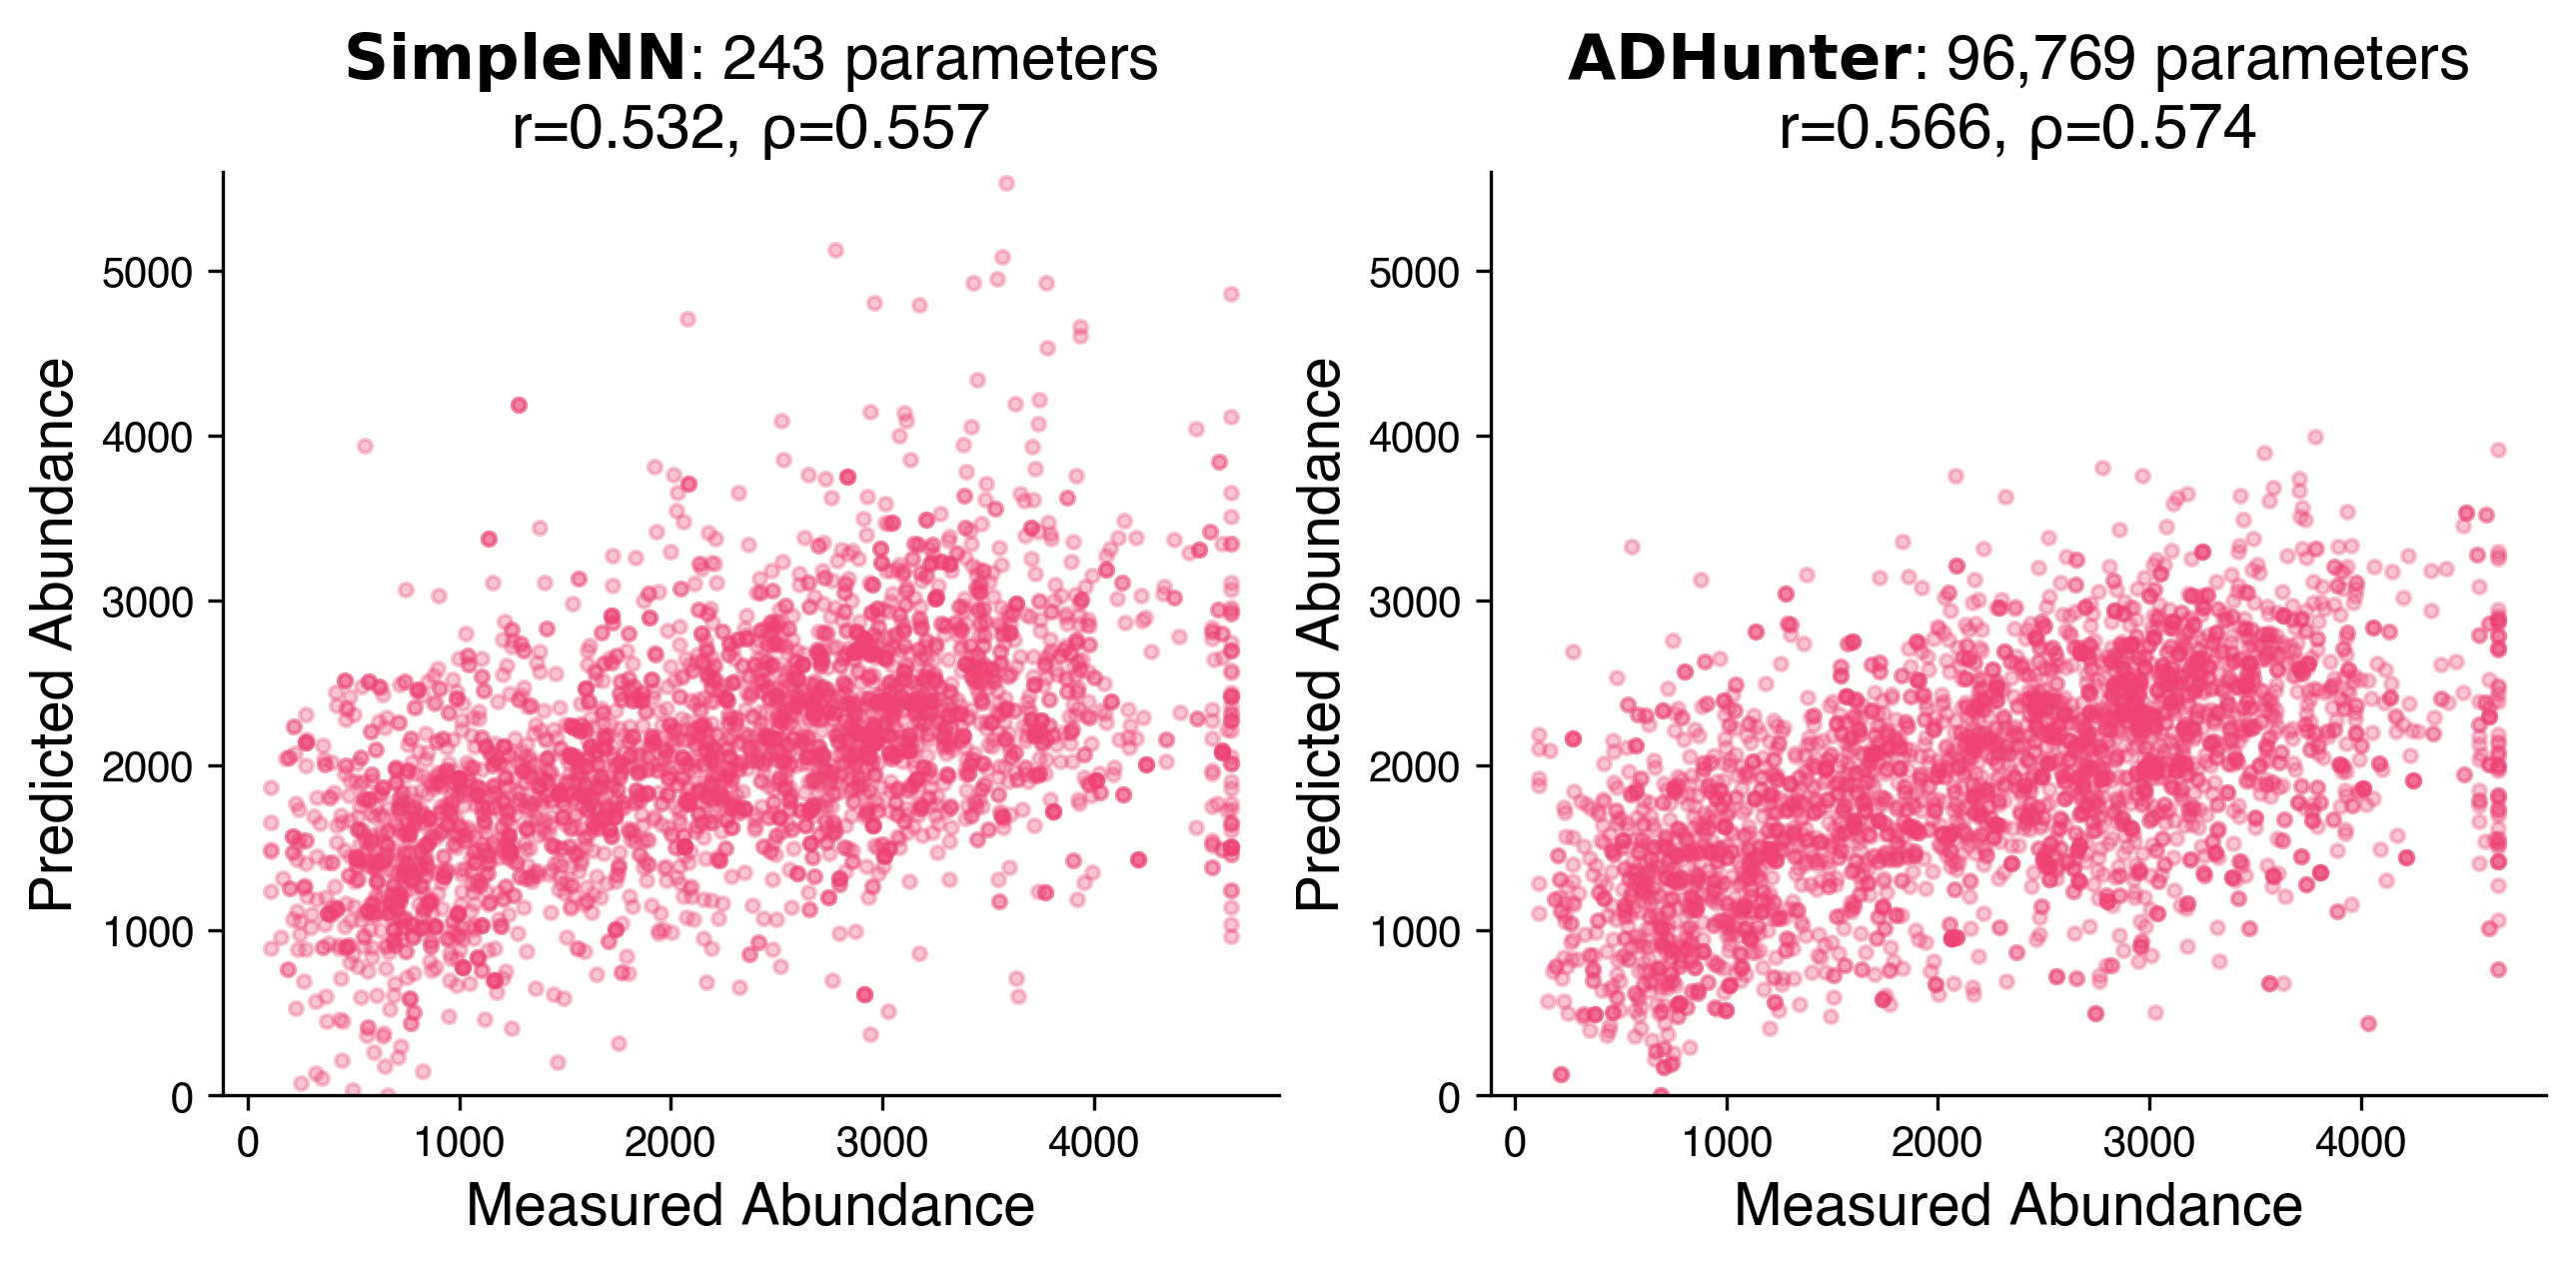

In [42]:
fig, axs = plt.subplots(1,2,figsize=(10,4))

tiles = [i for ls in test_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in test_seqs["40_tiles_exp_abundance"] for i in ls]
actual = actual + (list(other_tiles["abundance"]))
pred = [i for ls in test_seqs["biophysics_mcherry_pred"] for i in ls]
pred = pred + (list(other_tiles["biophysics_mcherry_pred"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[0].scatter(actual, pred, color='#EE4274', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = pearsonr(plotting_data["actual"].astype('float'), plotting_data["pred"].astype('float')).correlation 
axs[0].set_xlabel('Measured Abundance', fontsize=14)
axs[0].set_ylabel('Predicted Abundance', fontsize=14)
axs[0].set_ylim(0, 5600)
axs[0].set_title(r"$\bf{SimpleNN}$" +f': 243 parameters\nr={pearson:.3}, \u03C1={spearman:.3}', fontsize=15)

tiles = [i for ls in test_seqs["40_tiles"] for i in ls]
tiles = tiles + (list(other_tiles["aa_seq"]))
actual = [i for ls in test_seqs["40_tiles_exp_abundance"] for i in ls]
actual = actual + (list(other_tiles["abundance"]))
pred = [i for ls in test_seqs["adhunter_mcherry_pred"] for i in ls]
pred = pred + (list(other_tiles["adhunter_mcherry_pred"]))
plotting_data = pd.DataFrame((actual, pred, tiles)).T
plotting_data = plotting_data.dropna()
plotting_data.columns = ["actual", "pred", "aa_seq"]
plotting_data = plotting_data.drop_duplicates("aa_seq") 

axs[1].scatter(actual, pred, color='#EE4274', s=10, alpha=0.3)
spearman = spearmanr(plotting_data["actual"], plotting_data["pred"]).correlation
pearson = pearsonr(plotting_data["actual"].astype('float'), plotting_data["pred"].astype('float')).correlation #np.corrcoef(list(plotting_data["actual"].values), list(plotting_data["pred"].values))[0, 1]
axs[1].set_xlabel('Measured Abundance', fontsize=14)
axs[1].set_ylabel('Predicted Abundance', fontsize=14)
axs[1].set_ylim(0, 5600)
axs[1].set_title(r"$\bf{ADHunter}$" + f': 96,769 parameters\nr={pearson:.3}, \u03C1={spearman:.3}', fontsize=15)

sns.despine()

plt.savefig("figures/simple_abund_scatter_plots.pdf", format='pdf', bbox_inches='tight')

# Inspecting the parameters of the model

In [ ]:
def load_model(name, k):
    """
    Loads a SimpleNN-abund model.
    """
    model = ADModel_abund(size, k)
    model.load_state_dict(torch.load(f"{name}.pth"))
    return model

In [ ]:
# Order of AAs for plotting
amino_acids = ["R","K","H","D","E","M","I","L","V","A","F","Y","W","Q","N","S","T","G","P","C"]

def get_conv_weights(model, layer): 
    """
    Extracts the convolutional layer weights and
    returns them as a pandas dataframe
    """
    model_state_dict = model.state_dict()
    width = model_state_dict[layer].shape[0] * model_state_dict[layer].shape[2]
    conv_weight = model_state_dict[layer].detach().numpy().reshape(width,20)
    conv_weights = pd.DataFrame(conv_weight,columns = ["R","H","K","D","E","S","T","N","Q","C","G","P","A","V","I","L","M","F","Y","W"])
    conv_weights = conv_weights[amino_acids]
    return conv_weights

def get_linear_weights(model, layer, kernel_size):
    """
    Extracts the linear layer weights and
    returns them as a numpy array. Also returns the 
    corresponding x-axis values
    """
    linear_weights = (40 - kernel_size + 1)
    model_state_dict = model.state_dict()
    linear_weight = model_state_dict[layer].detach().numpy().reshape(linear_weights)
    x_vals = np.array(range(0,linear_weights))
    return linear_weight, x_vals


In [96]:
# This is setting up our colors for the plots

# Colors for convolutional filter
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # Blue, White, Red
n_bins = 100  # Number of color bins
cmap_name = "custom_colormap"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
custom_cmap.set_bad(color='white', alpha=1.0)  # Handle NaN values, if any

# Colors for AA labels
colors = {'A': 'purple', 'C': 'darkorange', 'E': 'blue', 'D': 'blue', 'G': 'darkorange', 
                  'F': 'indigo', 'I': 'purple', 'H': 'green', 'K': 'green', 'M': 'purple', 
                  'L': 'purple', 'N': 'darkslategray', 'Q': 'darkslategray', 'P': 'darkorange', 'S': 'darkslategray', 
                  'R': 'green', 'T': 'darkslategray', 'W': 'indigo', 'V': 'purple', 'Y': 'indigo'}

In [97]:
def make_row_plot(fig, kernel_size, model, row, lim, height_ratios, num_rows):
    """
    Core functionality for creating the convolutional filter plots. 
    Plots the convolution filter as a heatmap and the linear weights as a bar plot.

    Parameters
    ----------
    fig : matplotlib.figure.Figure
        Figure object created with plt.figure
    
    kernel_size : int
        The size of the convolutional filter

    model : ADModel_abund
        Loaded model (from which parameters will be extracted)
    
    row : int
        Which row in the overall figure should we fill in

    lim : float
        The max value for the heatmap

    height_ratios : list
        Ratio of heights between rows, length should correspond to number of rows in
        gridspec object

    num_rows : list
        The number of rows in the gridspec object

    Returns
    -------
    ax1 : maplotlib.Axes object
        Contains the heatmap
    ax2 : maplotlib.Axes object
        Contains the barplot
    im1 : maplotlib.Axes.imshow object
        The heatmap
    """

    # Load the convolutional and linear weights
    model_conv1 = get_conv_weights(model, "conv1.weight").T
    model_linear1, model_xvals1 = get_linear_weights(model, "linear1.weight", kernel_size)

    # Calculate how much of the figure the convolutional filter vs. linear weights will take up
    ratio1 = kernel_size 
    ratio2 = 40 - kernel_size + 1

    # GridSpec allows us to plot rows/columns with different dimensions
    # Here, we initalize the gridspec object with the total number of rows in our figure
    # But we only fill in the specific row that we are interested in
    # (When combined with many other gridspec objects, they will all line up and look good)
    gs1 = gridspec.GridSpec(2 + num_rows*2, 2, width_ratios=[ratio1, ratio2], height_ratios=height_ratios, figure=fig)

    # ax1 and ax2 are matplotlib axes
    ax1 = plt.subplot(gs1[row, 0])
    ax2 = plt.subplot(gs1[row, 1])

    # This is the code for plotting the convolutional filter as a heatmap
    # Min and max values of heatmap are passed by used
    im1 = ax1.imshow(model_conv1.to_numpy(), cmap=custom_cmap, aspect='auto',vmin=-lim,vmax=lim)
    ax1.set_yticks(range(len(model_conv1.index)), model_conv1.index)  # Label x-axis with column names
    ax1.set_xticks(np.arange(kernel_size, step=2))
    
    # This is to color the amino acid labels
    for ytic in ax1.get_yticklabels():
        if ytic.get_text() in colors.keys(): 
            ytic.set_color(colors[ytic.get_text()])
    ax1.tick_params(axis='x', which='major', labelsize=15) 
    ax1.tick_params(axis='y', which='major', labelsize=8) 

    # This is the code for plotting the linear weights as a bar graph
    ax2.bar(model_xvals1, model_linear1, color="grey")
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["right"].set_visible(False)
    ax2.spines["bottom"].set_position('zero')
    ax2.spines["bottom"].set_linewidth(2.5)

    ax2.spines['bottom'].set_bounds(min(model_xvals1) - 1, max(model_xvals1) + 1)
    
    # Remove all x-ticks for the bargraph
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])

    # Return axes objects
    return ax1, ax2, im1

In [ ]:
# Get another high performing model to display
best_models = model_results.sort_values("sum_rank").drop_duplicates(" kernel_size", keep='first')
file = best_models[best_models[' kernel_size'] == 30]["model_name"].values[0].removeprefix("../../") 
model_30 = load_model(file, 30)


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


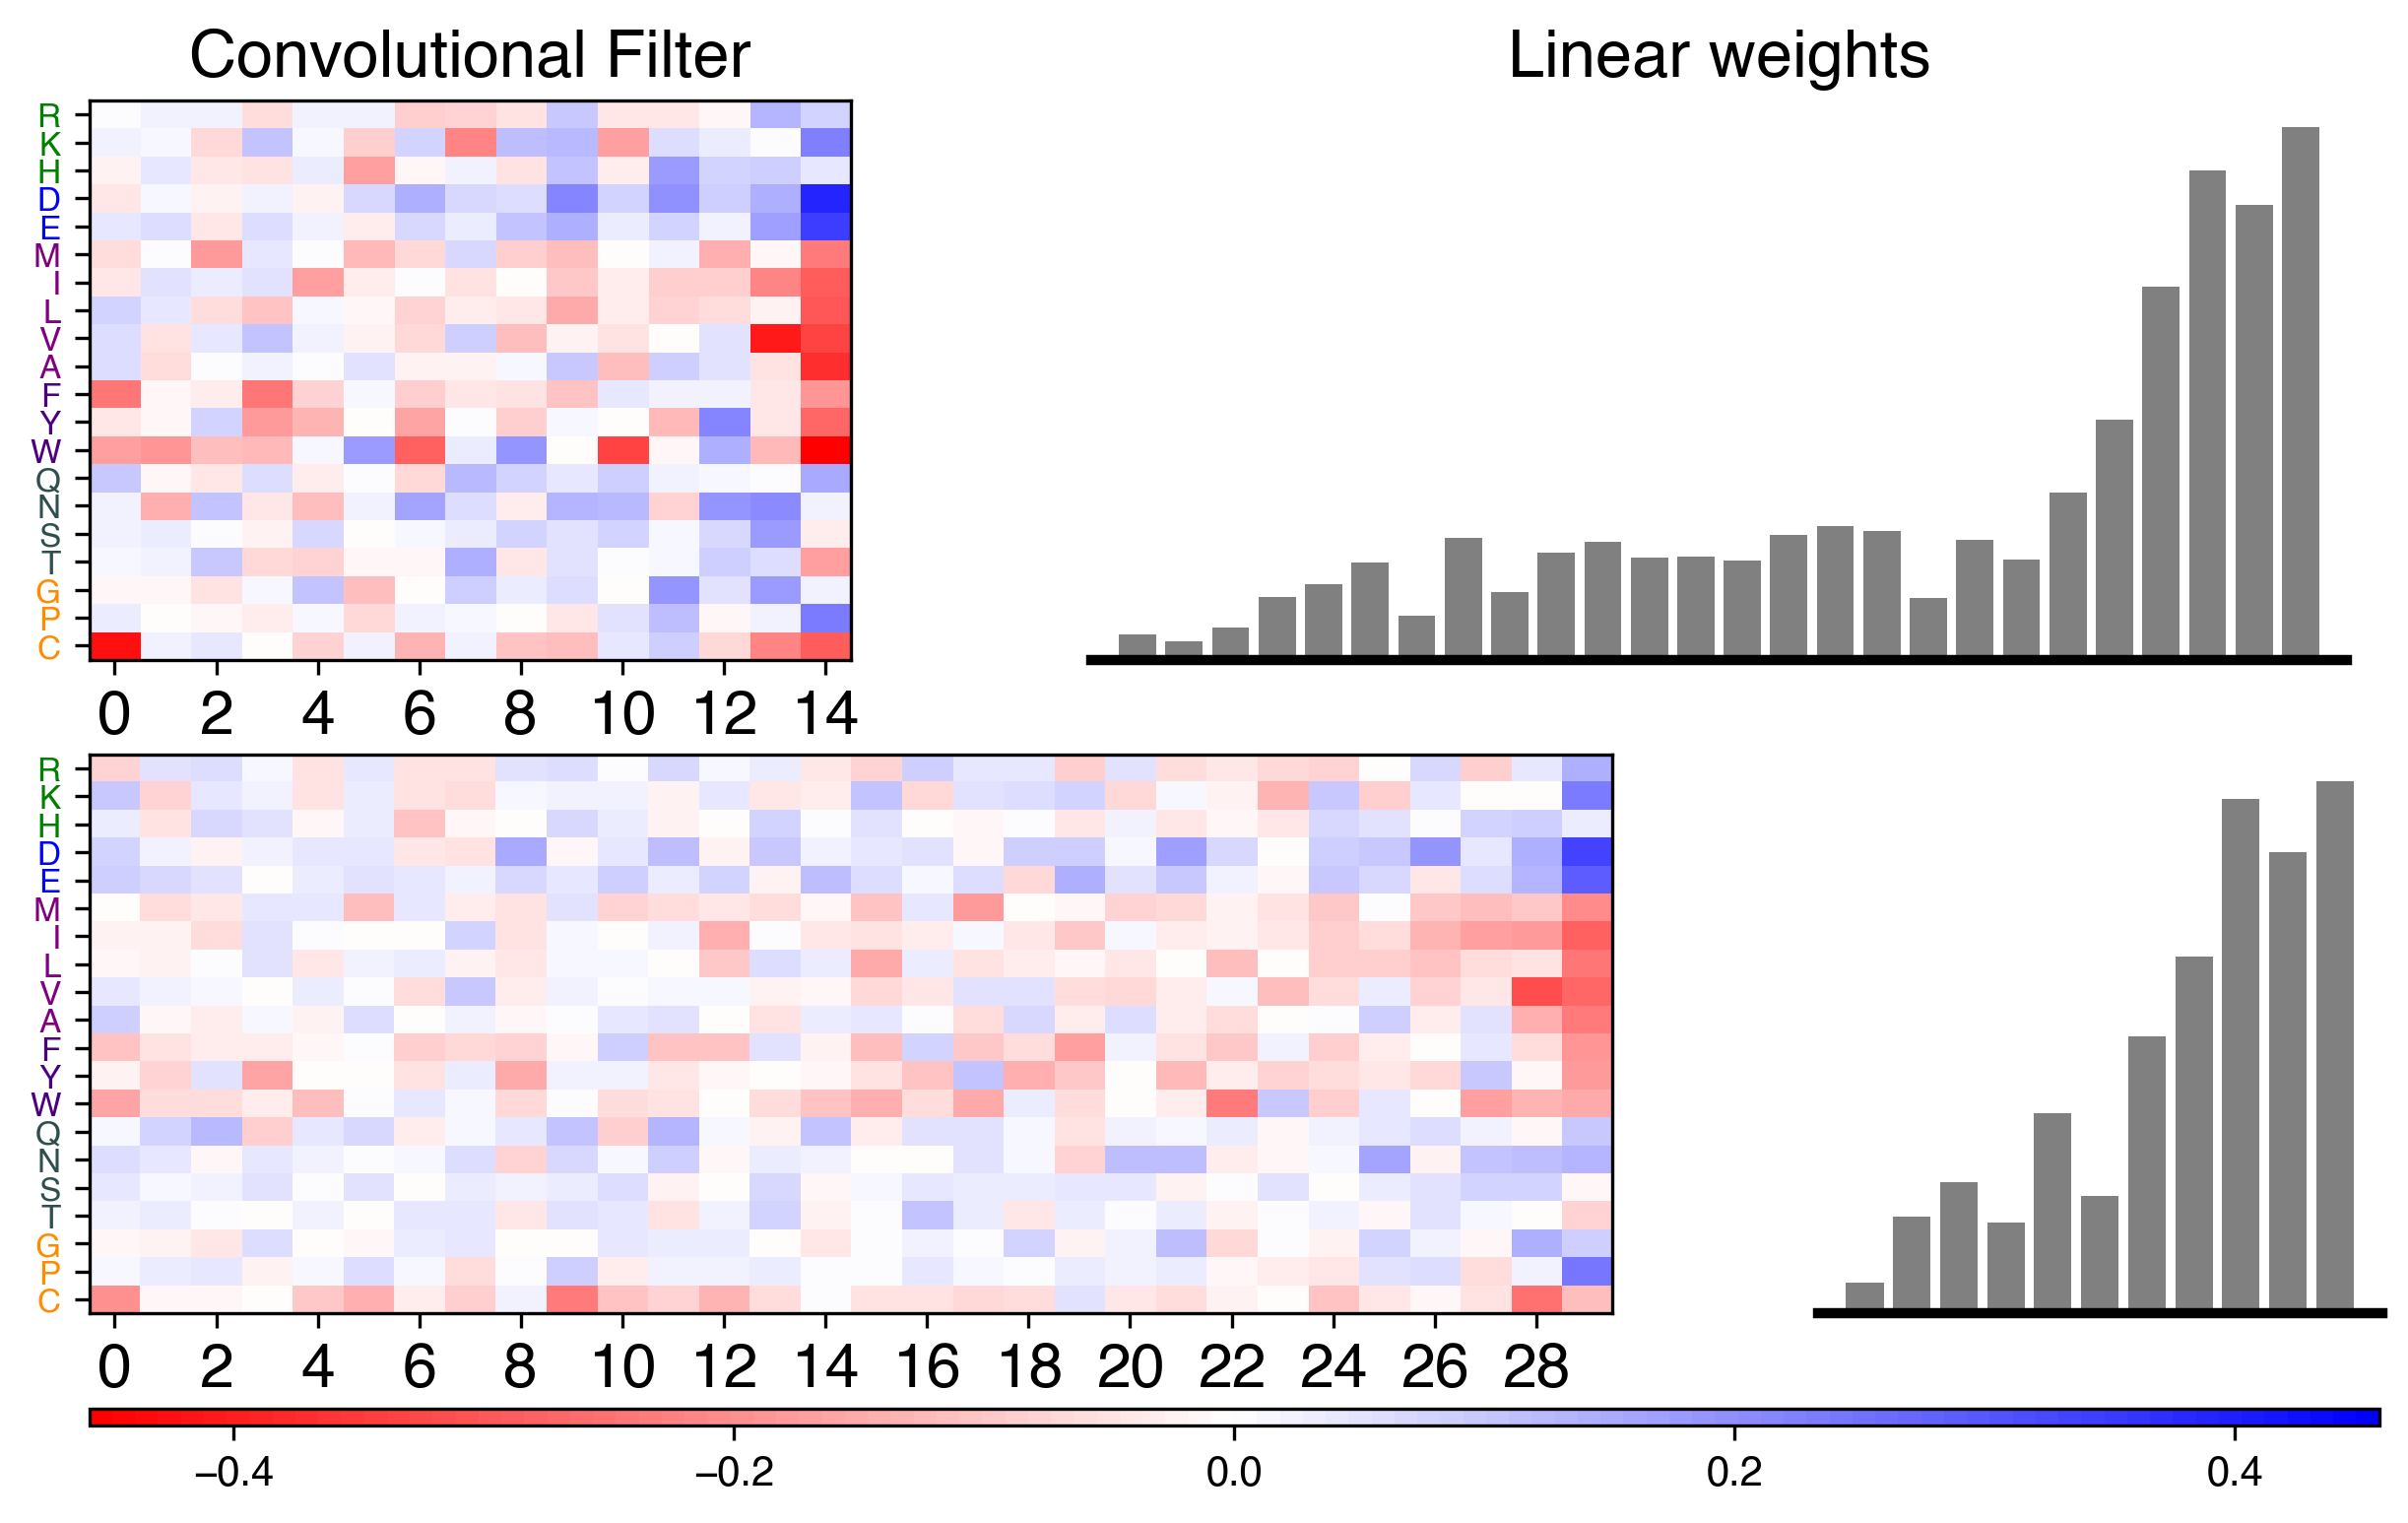

In [101]:
num_rows = 2

# Get the range for the heatmaps
models = [biophysical_model, model_30]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(10, 3*num_rows))

# We add in "padding" rows between the rows we care about
height_ratios = [.01] + [3.3, .1]*num_rows + [0.1]

# Create a gridspec object
gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)

# Adding the best NN parameters to the first row
ax1, ax2, im1 = make_row_plot(fig, kernel_size, biophysical_model, 1, lim, height_ratios, num_rows)
ax1.set_title("Convolutional Filter", fontsize=16)
ax2.set_title("Linear weights", fontsize=16)

# Adding another NN parameters to the second row (row 3 because of padding)
ax1, ax2, im1 = make_row_plot(fig, 30, model_30, 3, lim, height_ratios, num_rows)

# Create another gridspec object to span the whole figure (1 column) to display the colorbar
gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

fig.colorbar(im1,cax=cax1, orientation='horizontal')

plt.savefig("figures/simple_abund_parameters.pdf", format='pdf', bbox_inches='tight')


# Make a plot for all the filters

In [ ]:
# Load the best model at each filter size 

best_models = model_results.sort_values("sum_rank").drop_duplicates(" kernel_size", keep='first')

# Best size 5 kernel
file = best_models[best_models[' kernel_size'] == 5]["model_name"].values[0].removeprefix("../../") 
model_5 = load_model(file, 5)

# Best size 10 kernel
file = best_models[best_models[' kernel_size'] == 10]["model_name"].values[0].removeprefix("../../") 
model_10 = load_model(file, 10)

# Best size 15 kernel
file = best_models[best_models[' kernel_size'] == 15]["model_name"].values[0].removeprefix("../../") 
model_15 = load_model(file, 15)

# Best size 20 kernel
file = file = best_models[best_models[' kernel_size'] == 20]["model_name"].values[0].removeprefix("../../") 
model_20 = load_model(file, 20)

# Best size 30 kernel
file = best_models[best_models[' kernel_size'] == 30]["model_name"].values[0].removeprefix("../../") 
model_30 = load_model(file, 30)

# Best size 40 kernel 
file = best_models[best_models[' kernel_size'] == 40]["model_name"].values[0].removeprefix("../../") 
model_40 = load_model(file, 40)


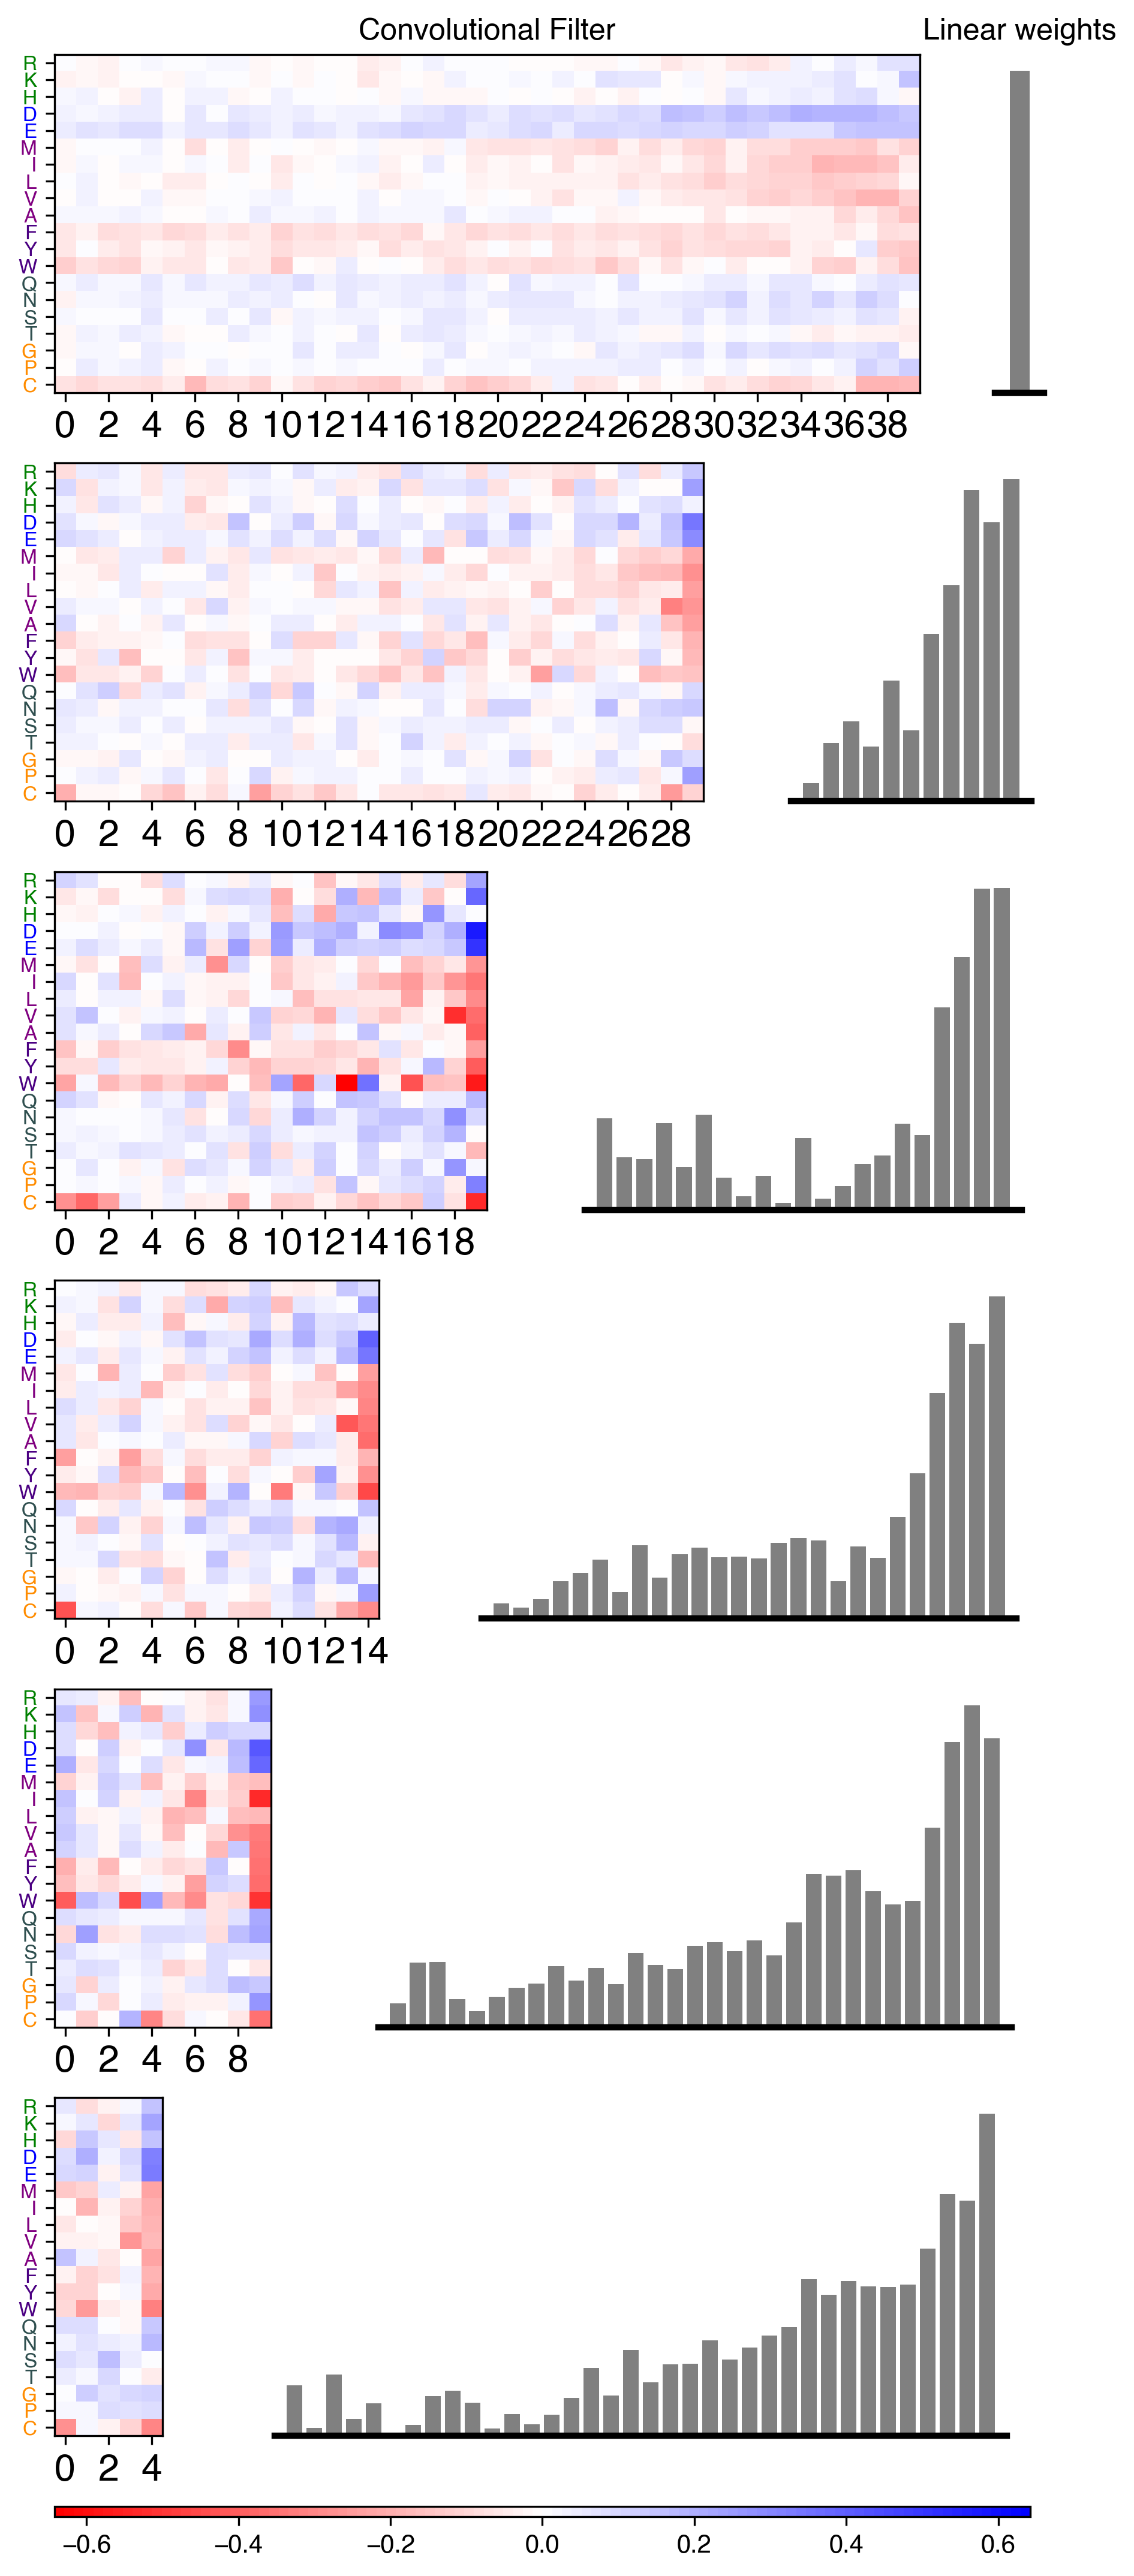

In [ ]:
num_rows = 6

# Get the range for the heatmaps
models = [model_5, model_10, model_15, model_20, model_30, model_40]
conv_weights = []

for model in models: 
    conv_weights += list(get_conv_weights(model, "conv1.weight").T.values.flatten())

lim = max([abs(w) for w in conv_weights])

# Create a figure
fig = plt.figure(figsize=(7, 3*num_rows))
title_font = {'fontsize': 15, 'fontweight': 'bold', 'fontname': 'Arial'}

# We add in "padding" rows between the rows we care about
height_ratios = [.01] + [3.3, .1]*num_rows + [.1]

# Create a gridspec object
gs1 = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)

# Adding the size 40 NN parameters to the first row
ax1, ax2, im1 = make_row_plot(fig, 40, model_40, 1, lim, height_ratios, num_rows)

# Add titles to the first row
ax1.set_title("Convolutional Filter", fontsize=12)
ax2.set_title("Linear weights", fontsize=12)

# Adding the other NN parameters (row count increases by 2 because of padding)
make_row_plot(fig, 30, model_30, 3, lim, height_ratios, num_rows)
make_row_plot(fig, 20, model_20, 5, lim, height_ratios, num_rows)
make_row_plot(fig, 15, model_15, 7, lim, height_ratios, num_rows)
make_row_plot(fig, 10, model_10, 9, lim, height_ratios, num_rows)
make_row_plot(fig, 5, model_5, 11, lim, height_ratios, num_rows)

# Create another gridspec object to span the whole figure (1 column) to display the colorbar
gs_cb = gridspec.GridSpec(2 + num_rows*2, 1, width_ratios=[1], height_ratios=height_ratios, figure=fig)
cax1 = plt.subplot(gs_cb[-1,0])

# Add the colorbar
fig.colorbar(im1,cax=cax1, orientation='horizontal')

# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.pdf', dpi=1000, bbox_inches='tight')
# plt.savefig('figures/feature_interpretability_abundance_all_vs_all.png', dpi=1000, bbox_inches='tight')

# Make histograms of abundance

In [ ]:
# Reading in the data
data = pd.read_csv("Data/pm_gcn4_sort2_pools_allchannels_wrangled.csv")

In [ ]:
# Defining amino acid types
positives = ["R", "K"]
negatives = ["D", "E"]

hydrophobics = ["M", "I", "L", "V", "A", "F", "Y", "W"]
aromatics = ["W", "F", "Y"]

In [ ]:
def contains_three_hydrophobics(seq):
    """
    Function to determine if seq contains three adjacent hydrophobic
    """
    for i in range(len(seq)-2):
        if seq[i] in hydrophobics:
            if seq[i+1] in hydrophobics:
                if seq[i+2] in hydrophobics:
                    return True
    return False

def contains_two_hydrophobics(seq):
    """
    Function to determine if seq contains two adjacent hydrophobic
    """
    for i in range(len(seq)-1):
        if seq[i] in hydrophobics:
            if seq[i+1] in hydrophobics:
                return True
    return False


def contains_one_hydrophobics(seq):
    """
    Function to determine if seq contains at least one hydrophobic
    """
    for i in range(len(seq)):
        if seq[i] in hydrophobics:
            return True
    return False

In [ ]:
# For every sequence, determine whether it ends in hydrophobic/charged aa
data["ends_w_charge"] = [(s[-1] in positives) | (s[-1] in negatives) for s in data["aa_seq"]]
data["ends_w_negative"] = [(s[-1] in negatives) for s in data["aa_seq"]]
data["ends_w_positive"] = [(s[-1] in positives) for s in data["aa_seq"]]
data["ends_w_hydrophobic"] = [(s[-1] in hydrophobics) for s in data["aa_seq"]]

# For every sequence, determine whether it ends in two+ hydrophobic/charged aa
data["ends_w_two_charge"] = [((s[-1] in positives) | (s[-1] in negatives)) & ((s[-2] in positives) | (s[-2] in negatives)) for s in data["aa_seq"]]
data["ends_w_two_hydrophobic"] = [(s[-1] in hydrophobics) & (s[-2] in hydrophobics) for s in data["aa_seq"]]

# For every sequence, determine whether it ends in three+ hydrophobic/charged aa
data["ends_w_three_charge"] = [((s[-1] in positives) | (s[-1] in negatives)) & ((s[-2] in positives) | (s[-2] in negatives)) & ((s[-3] in positives) | (s[-3] in negatives)) for s in data["aa_seq"]]
data["ends_w_three_hydrophobic"] = [(s[-1] in hydrophobics) & (s[-2] in hydrophobics) & (s[-3] in hydrophobics) for s in data["aa_seq"]]

# Calculate total charge/hydrophobic content
data["total_charge"] = [s.count(positives[0]) + s.count(positives[1]) + s.count(negatives[0]) + s.count(negatives[1]) for s in data["aa_seq"]]
data["total_negatives"] = [s.count(negatives[0]) + s.count(negatives[1]) for s in data["aa_seq"]]
data["total_positives"] = [s.count(positives[0]) + s.count(positives[1]) for s in data["aa_seq"]]
data["total_hydrophobics"] = [s.count(hydrophobics[0]) + s.count(hydrophobics[1]) + s.count(hydrophobics[2]) + s.count(hydrophobics[3]) + s.count(hydrophobics[4]) + s.count(hydrophobics[5]) + s.count(hydrophobics[6]) + s.count(hydrophobics[7]) for s in data["aa_seq"]]
data["total_aromatics"] = [s.count(aromatics[0]) + s.count(aromatics[1]) + s.count(aromatics[2]) for s in data["aa_seq"]]

# For every sequence, determine if it has adjacent hydrophobics anywhere
data["contains_three_hydrophobic"] = [contains_three_hydrophobics(s) for s in data["aa_seq"]]
data["contains_two_hydrophobic"] = [contains_two_hydrophobics(s) for s in data["aa_seq"]]
data["contains_hydrophobic"] = [contains_one_hydrophobics(s) for s in data["aa_seq"]]

/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_31331/33096939.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_charge"].unique()), patch_artist=True)


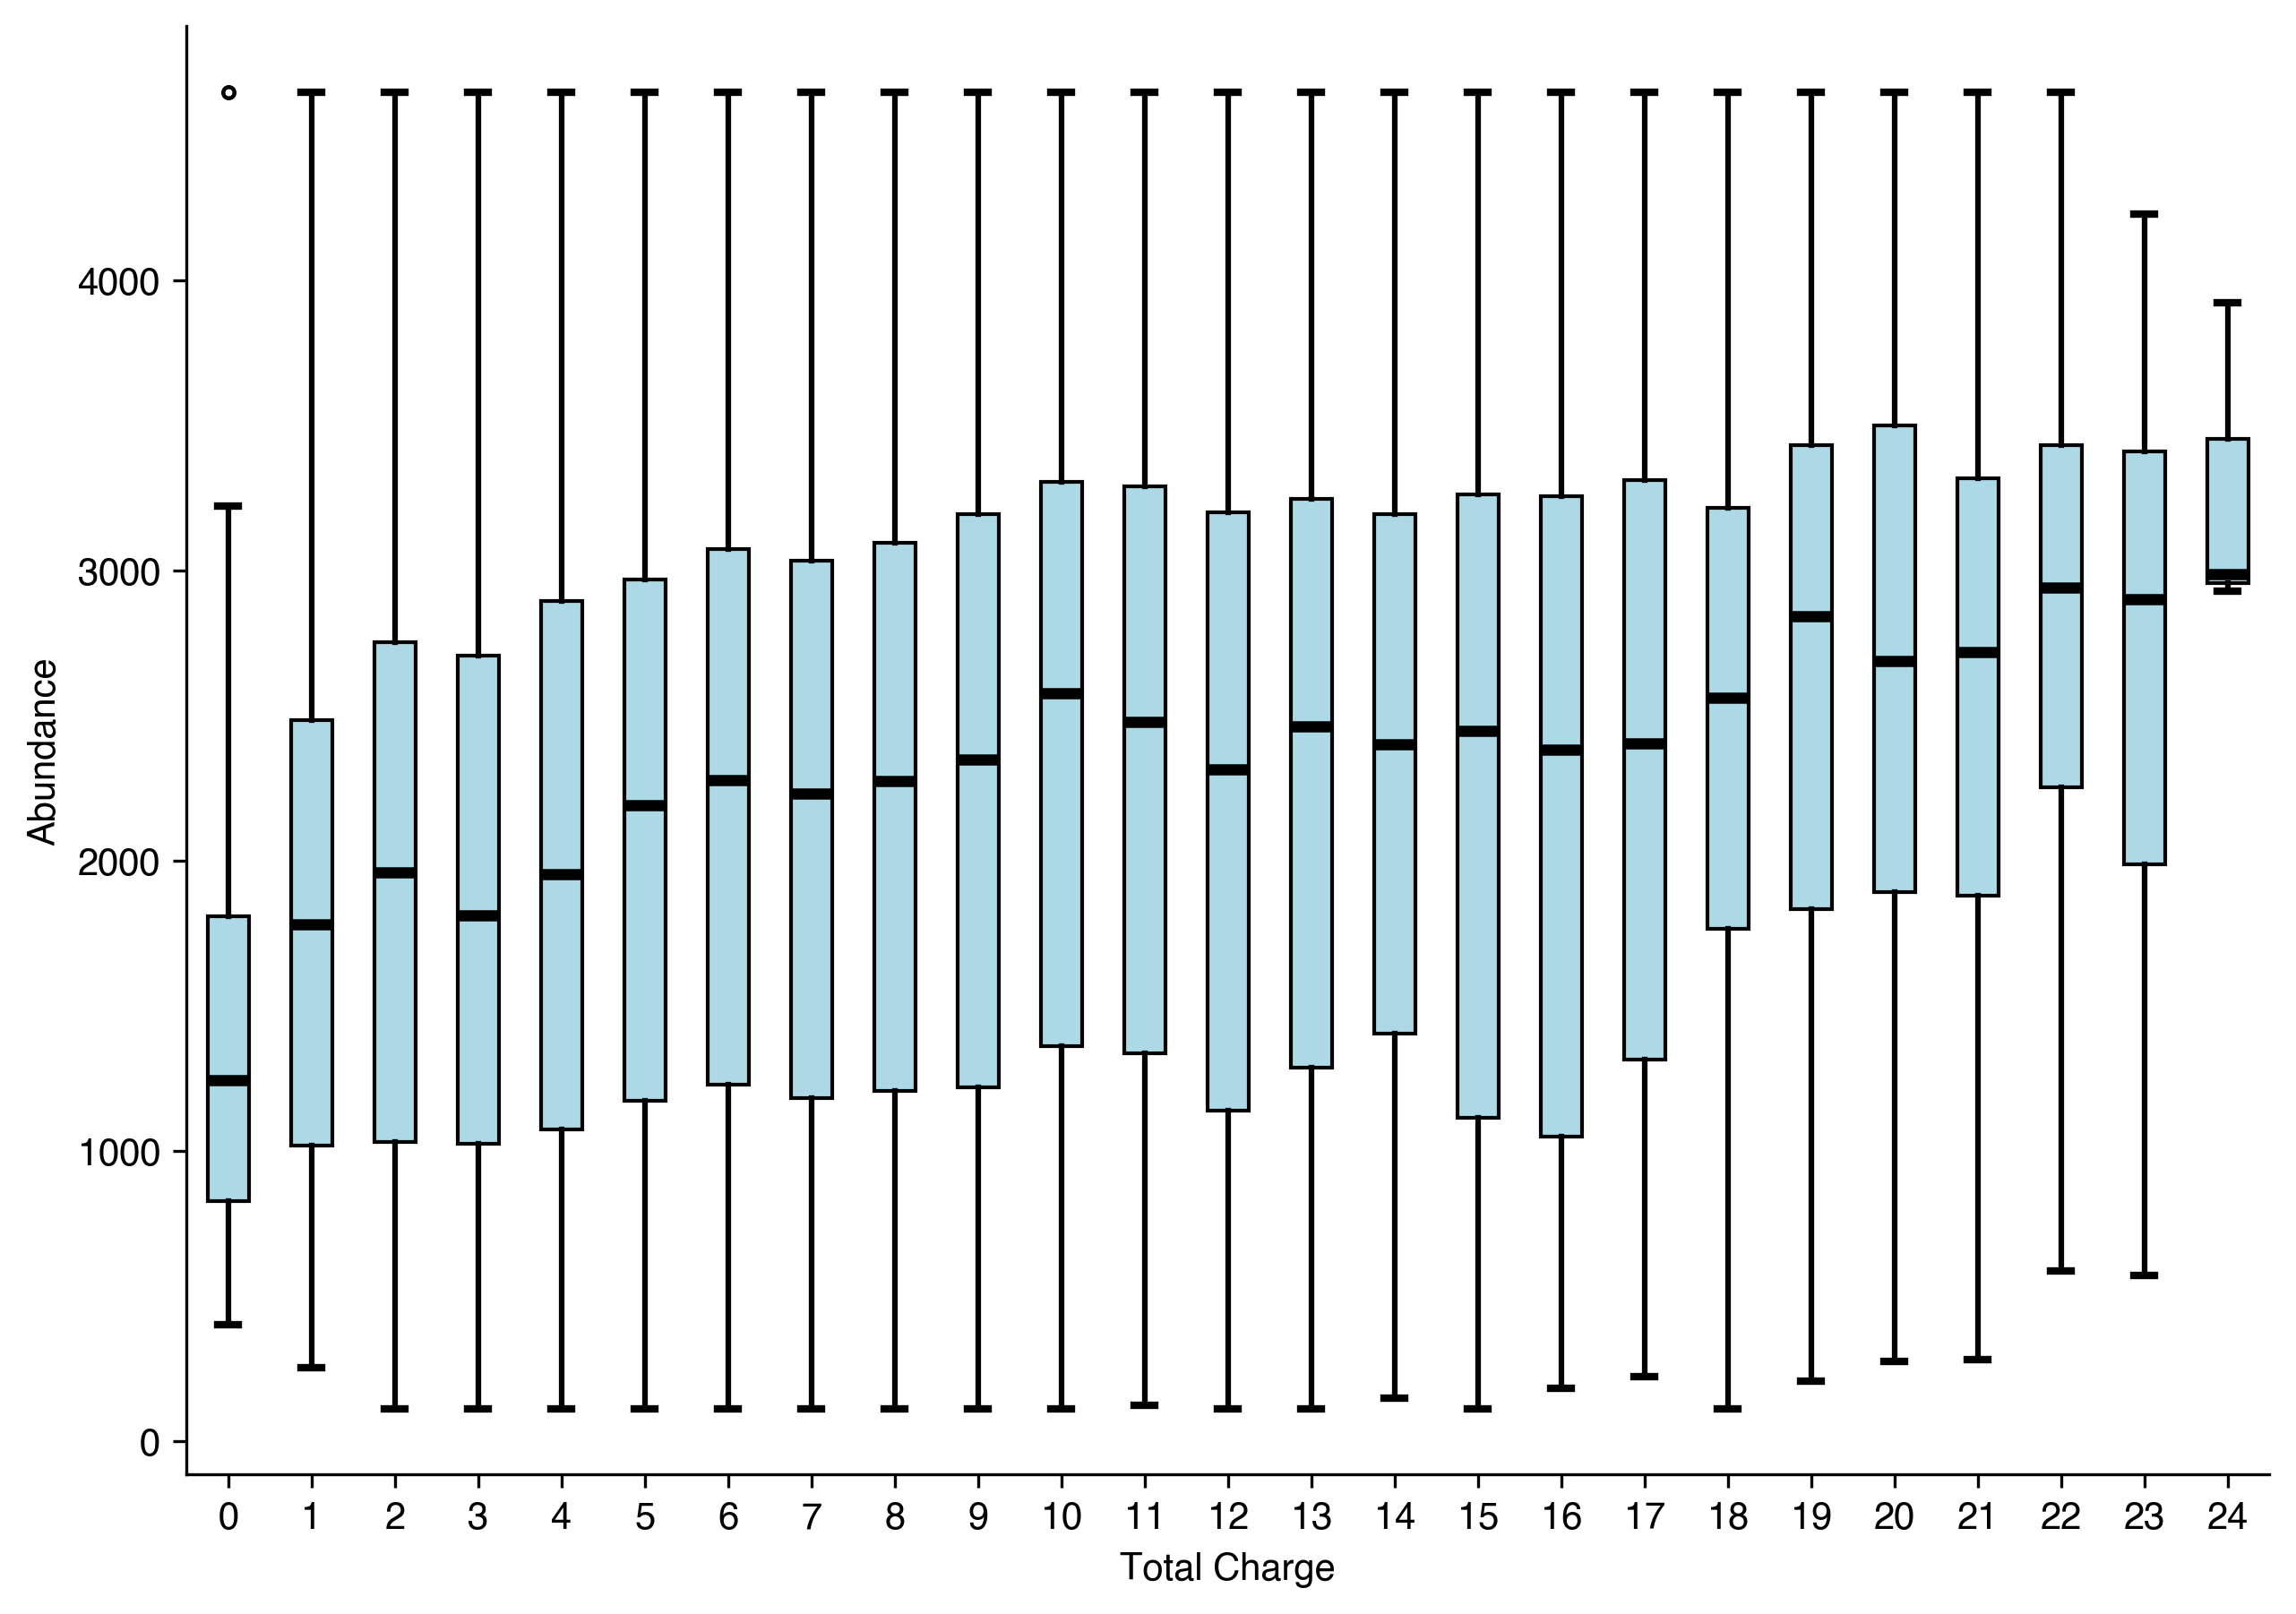

In [ ]:
# Code to create a boxplot of total abundance for different charges

grouped_data = [data[data["total_charge"] == charge]["abundance"] for charge in sorted(data["total_charge"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_charge"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_charge"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("lightblue")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Charge")
ax.set_ylabel("Abundance")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_31331/2264176943.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_negatives"].unique()), patch_artist=True)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


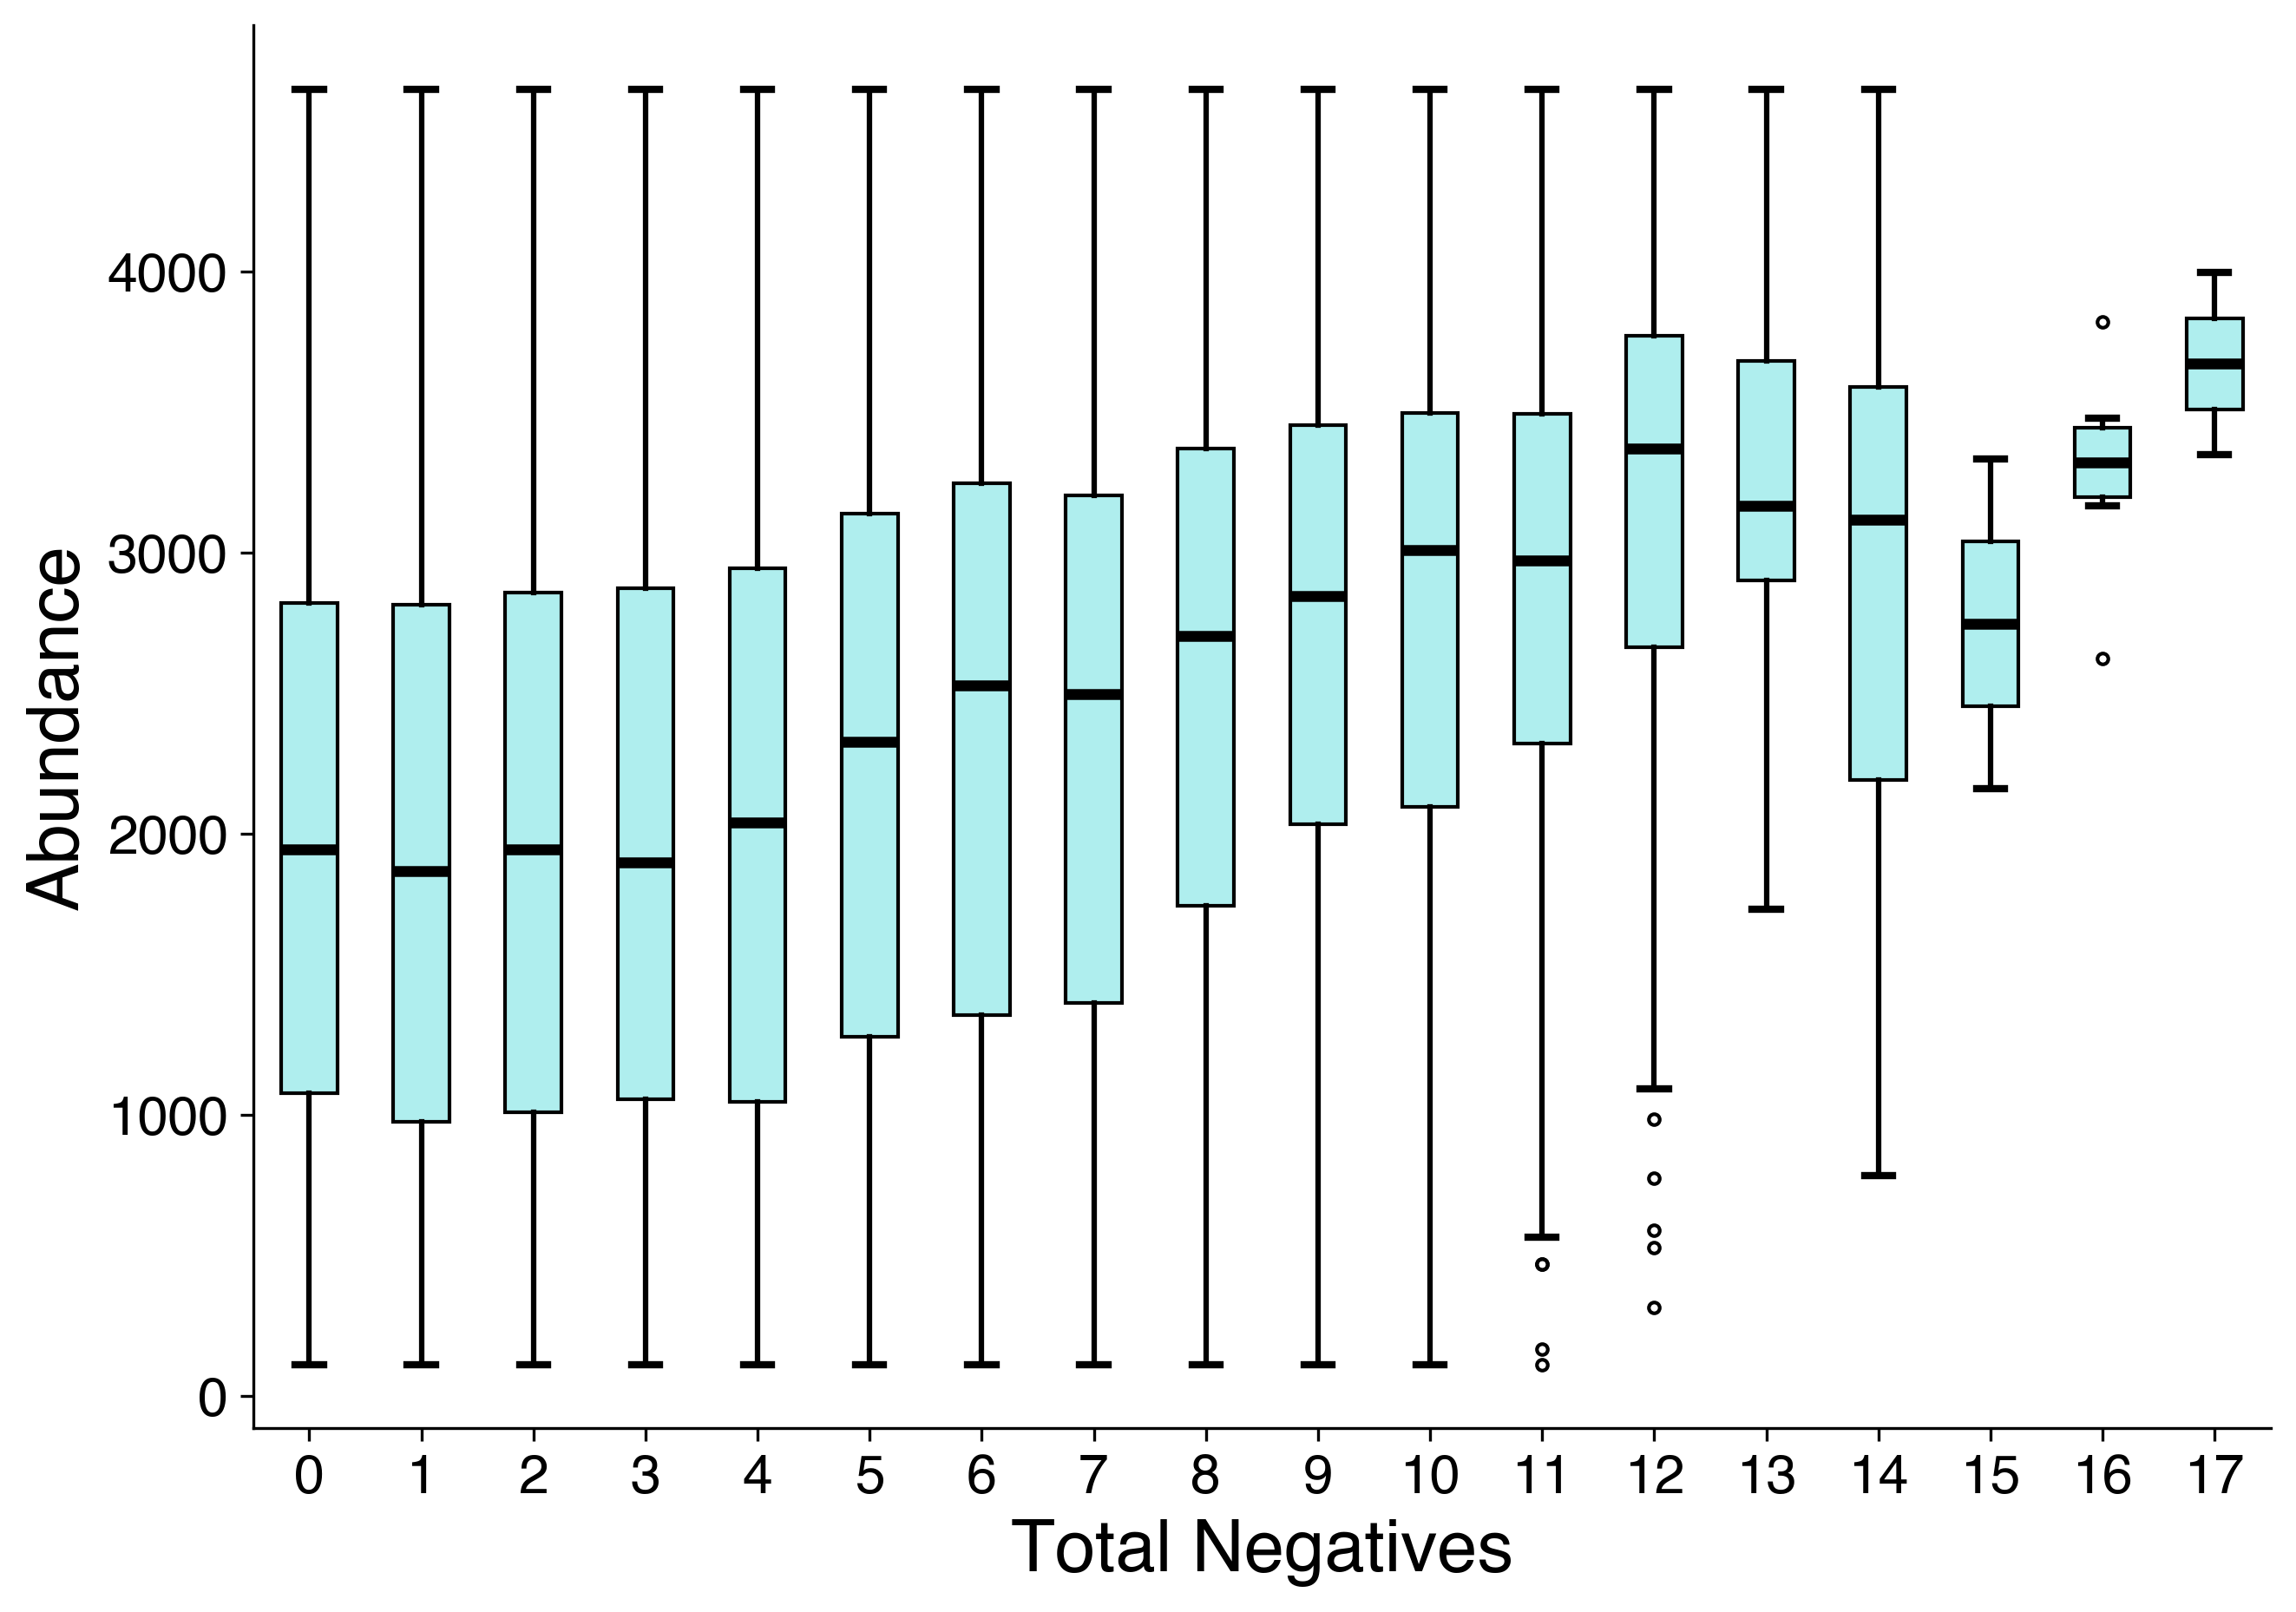

In [ ]:
# Code to create a boxplot of total abundance per negative count 

grouped_data = [data[data["total_negatives"] == charge]["abundance"] for charge in sorted(data["total_negatives"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_negatives"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_negatives"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("paleturquoise")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Negatives", fontsize=20)
ax.set_ylabel("Abundance", fontsize=20)

ax.tick_params(labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_barplot_negative.pdf", format='pdf', bbox_inches='tight')


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_31331/3666665809.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_positives"].unique()), patch_artist=True)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


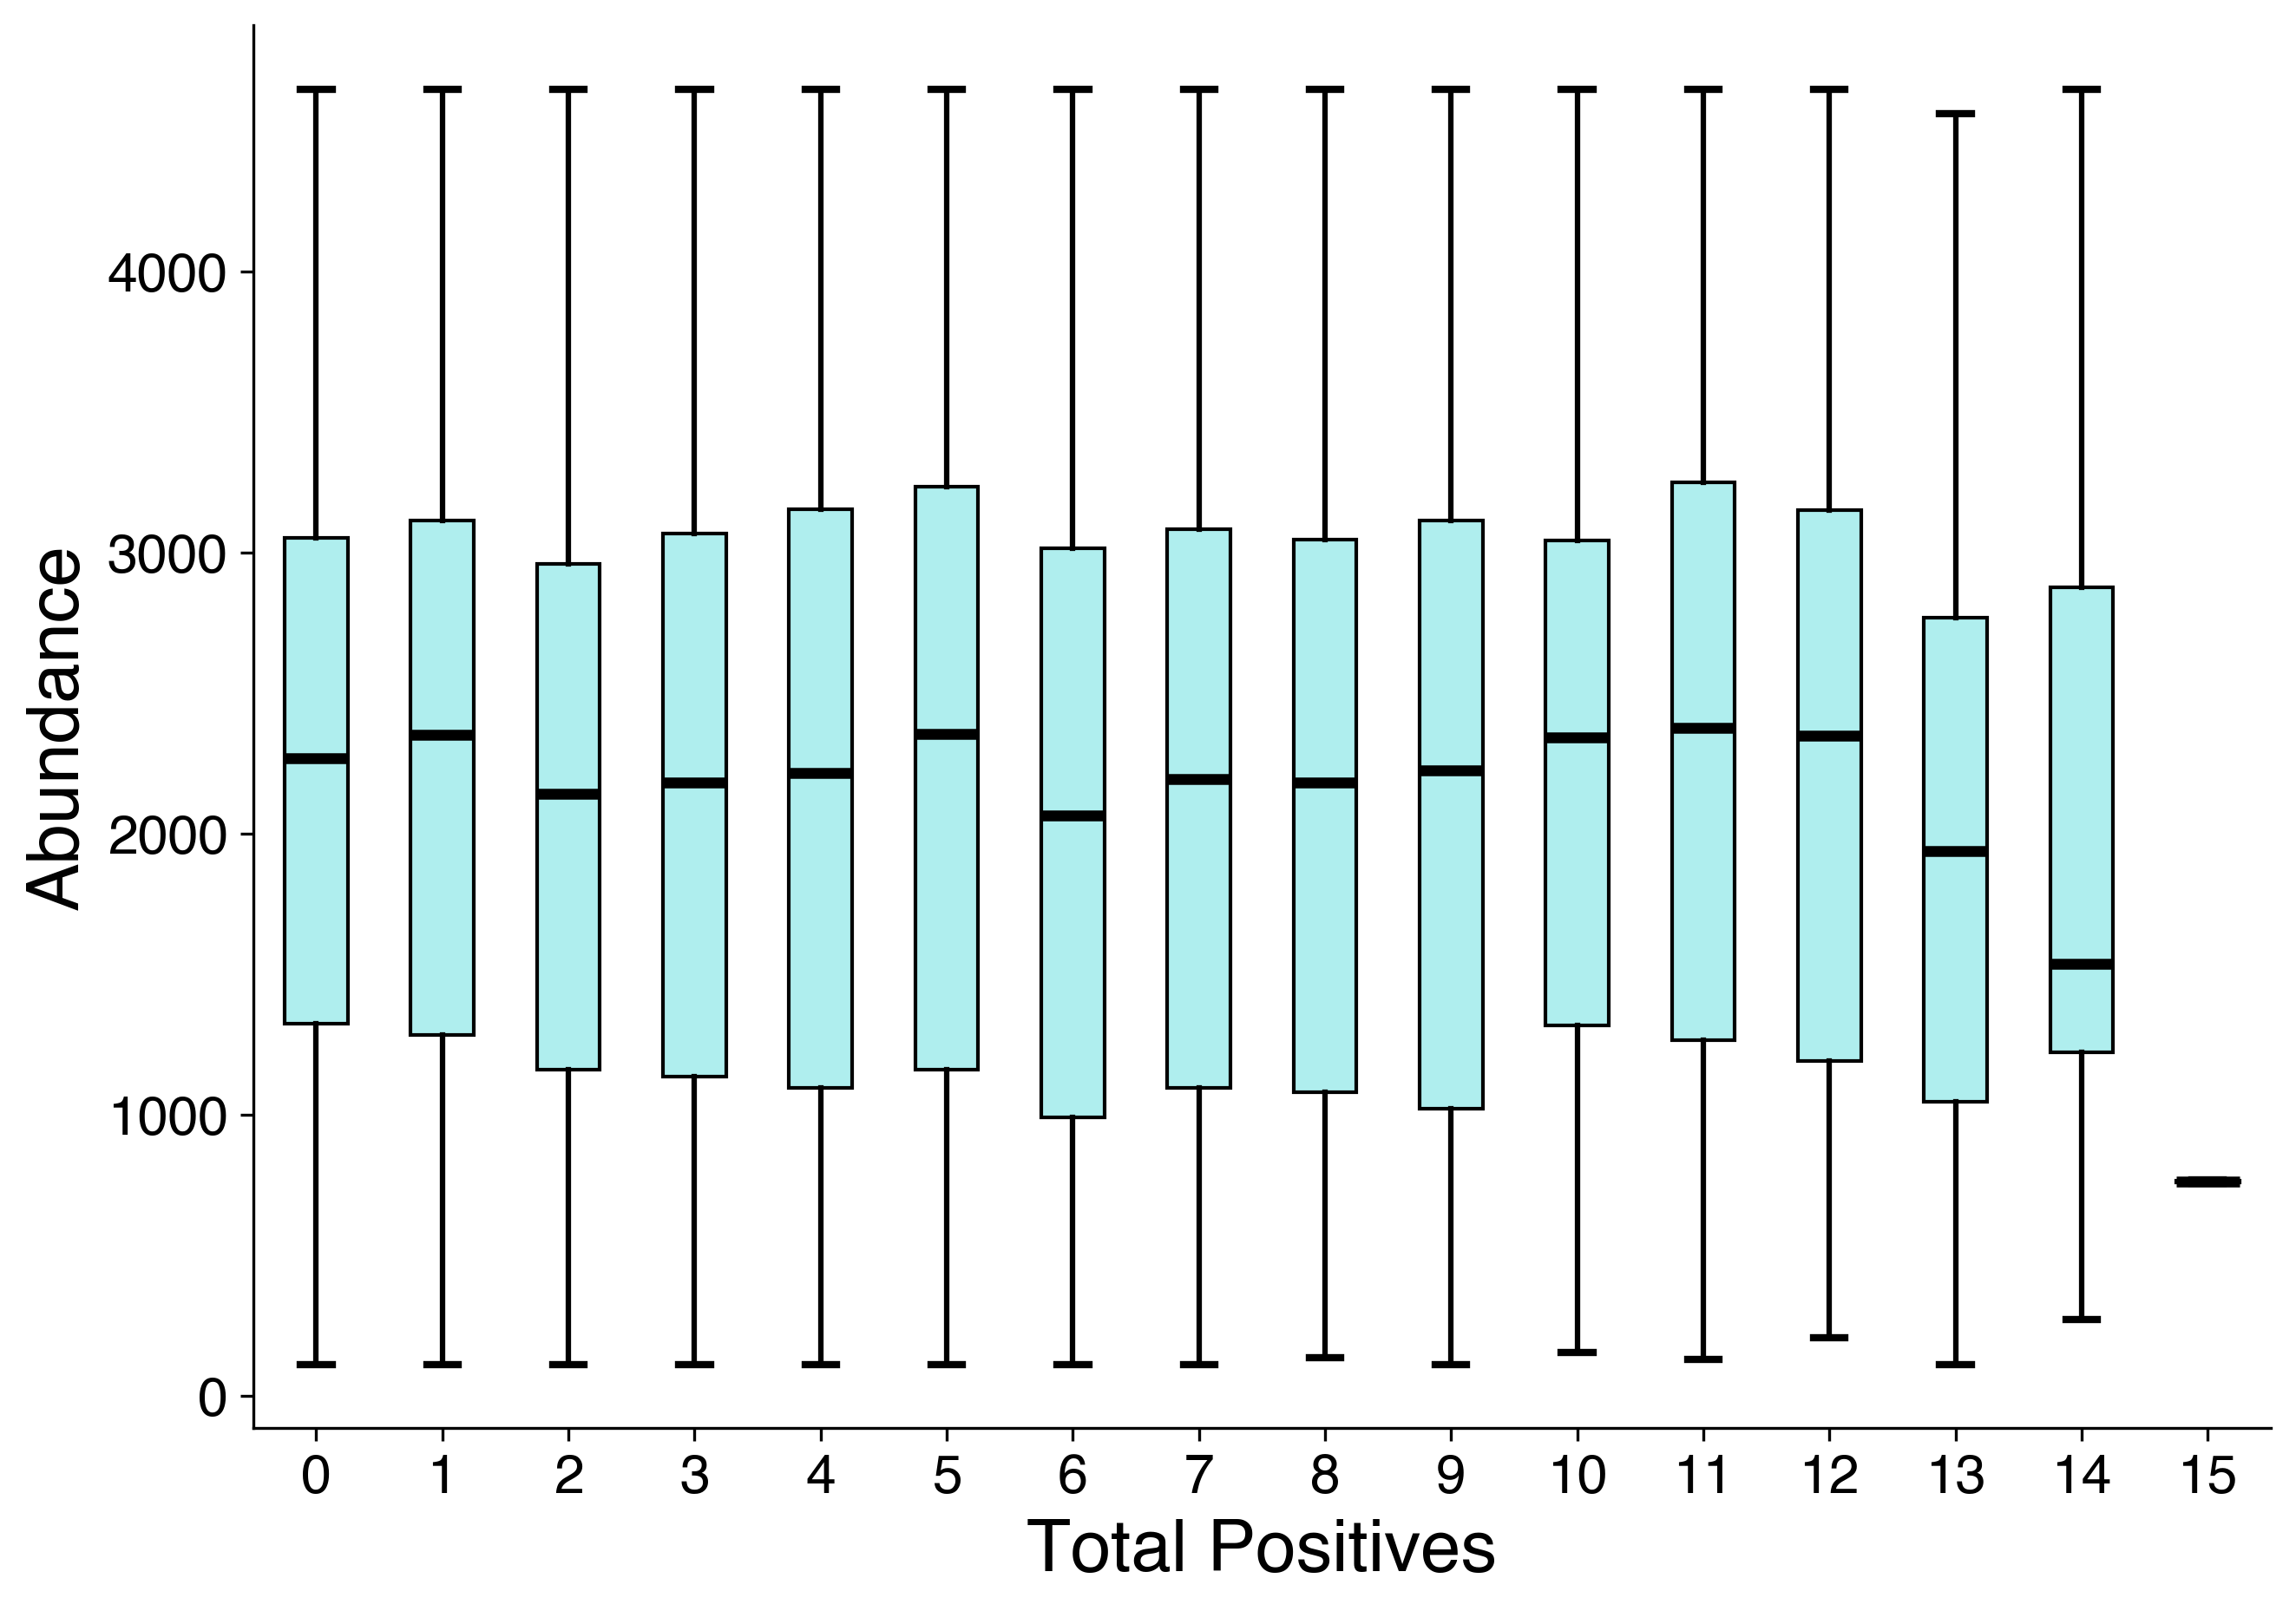

In [ ]:
# Code to create a boxplot of total abundance per positive count 

grouped_data = [data[data["total_positives"] == charge]["abundance"] for charge in sorted(data["total_positives"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_positives"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_positives"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("paleturquoise")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Positives", fontsize=20)
ax.set_ylabel("Abundance", fontsize=20)

ax.tick_params(labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_barplot_positive.pdf", format='pdf', bbox_inches='tight')


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_31331/1569290240.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_hydrophobics"].unique()), patch_artist=True)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


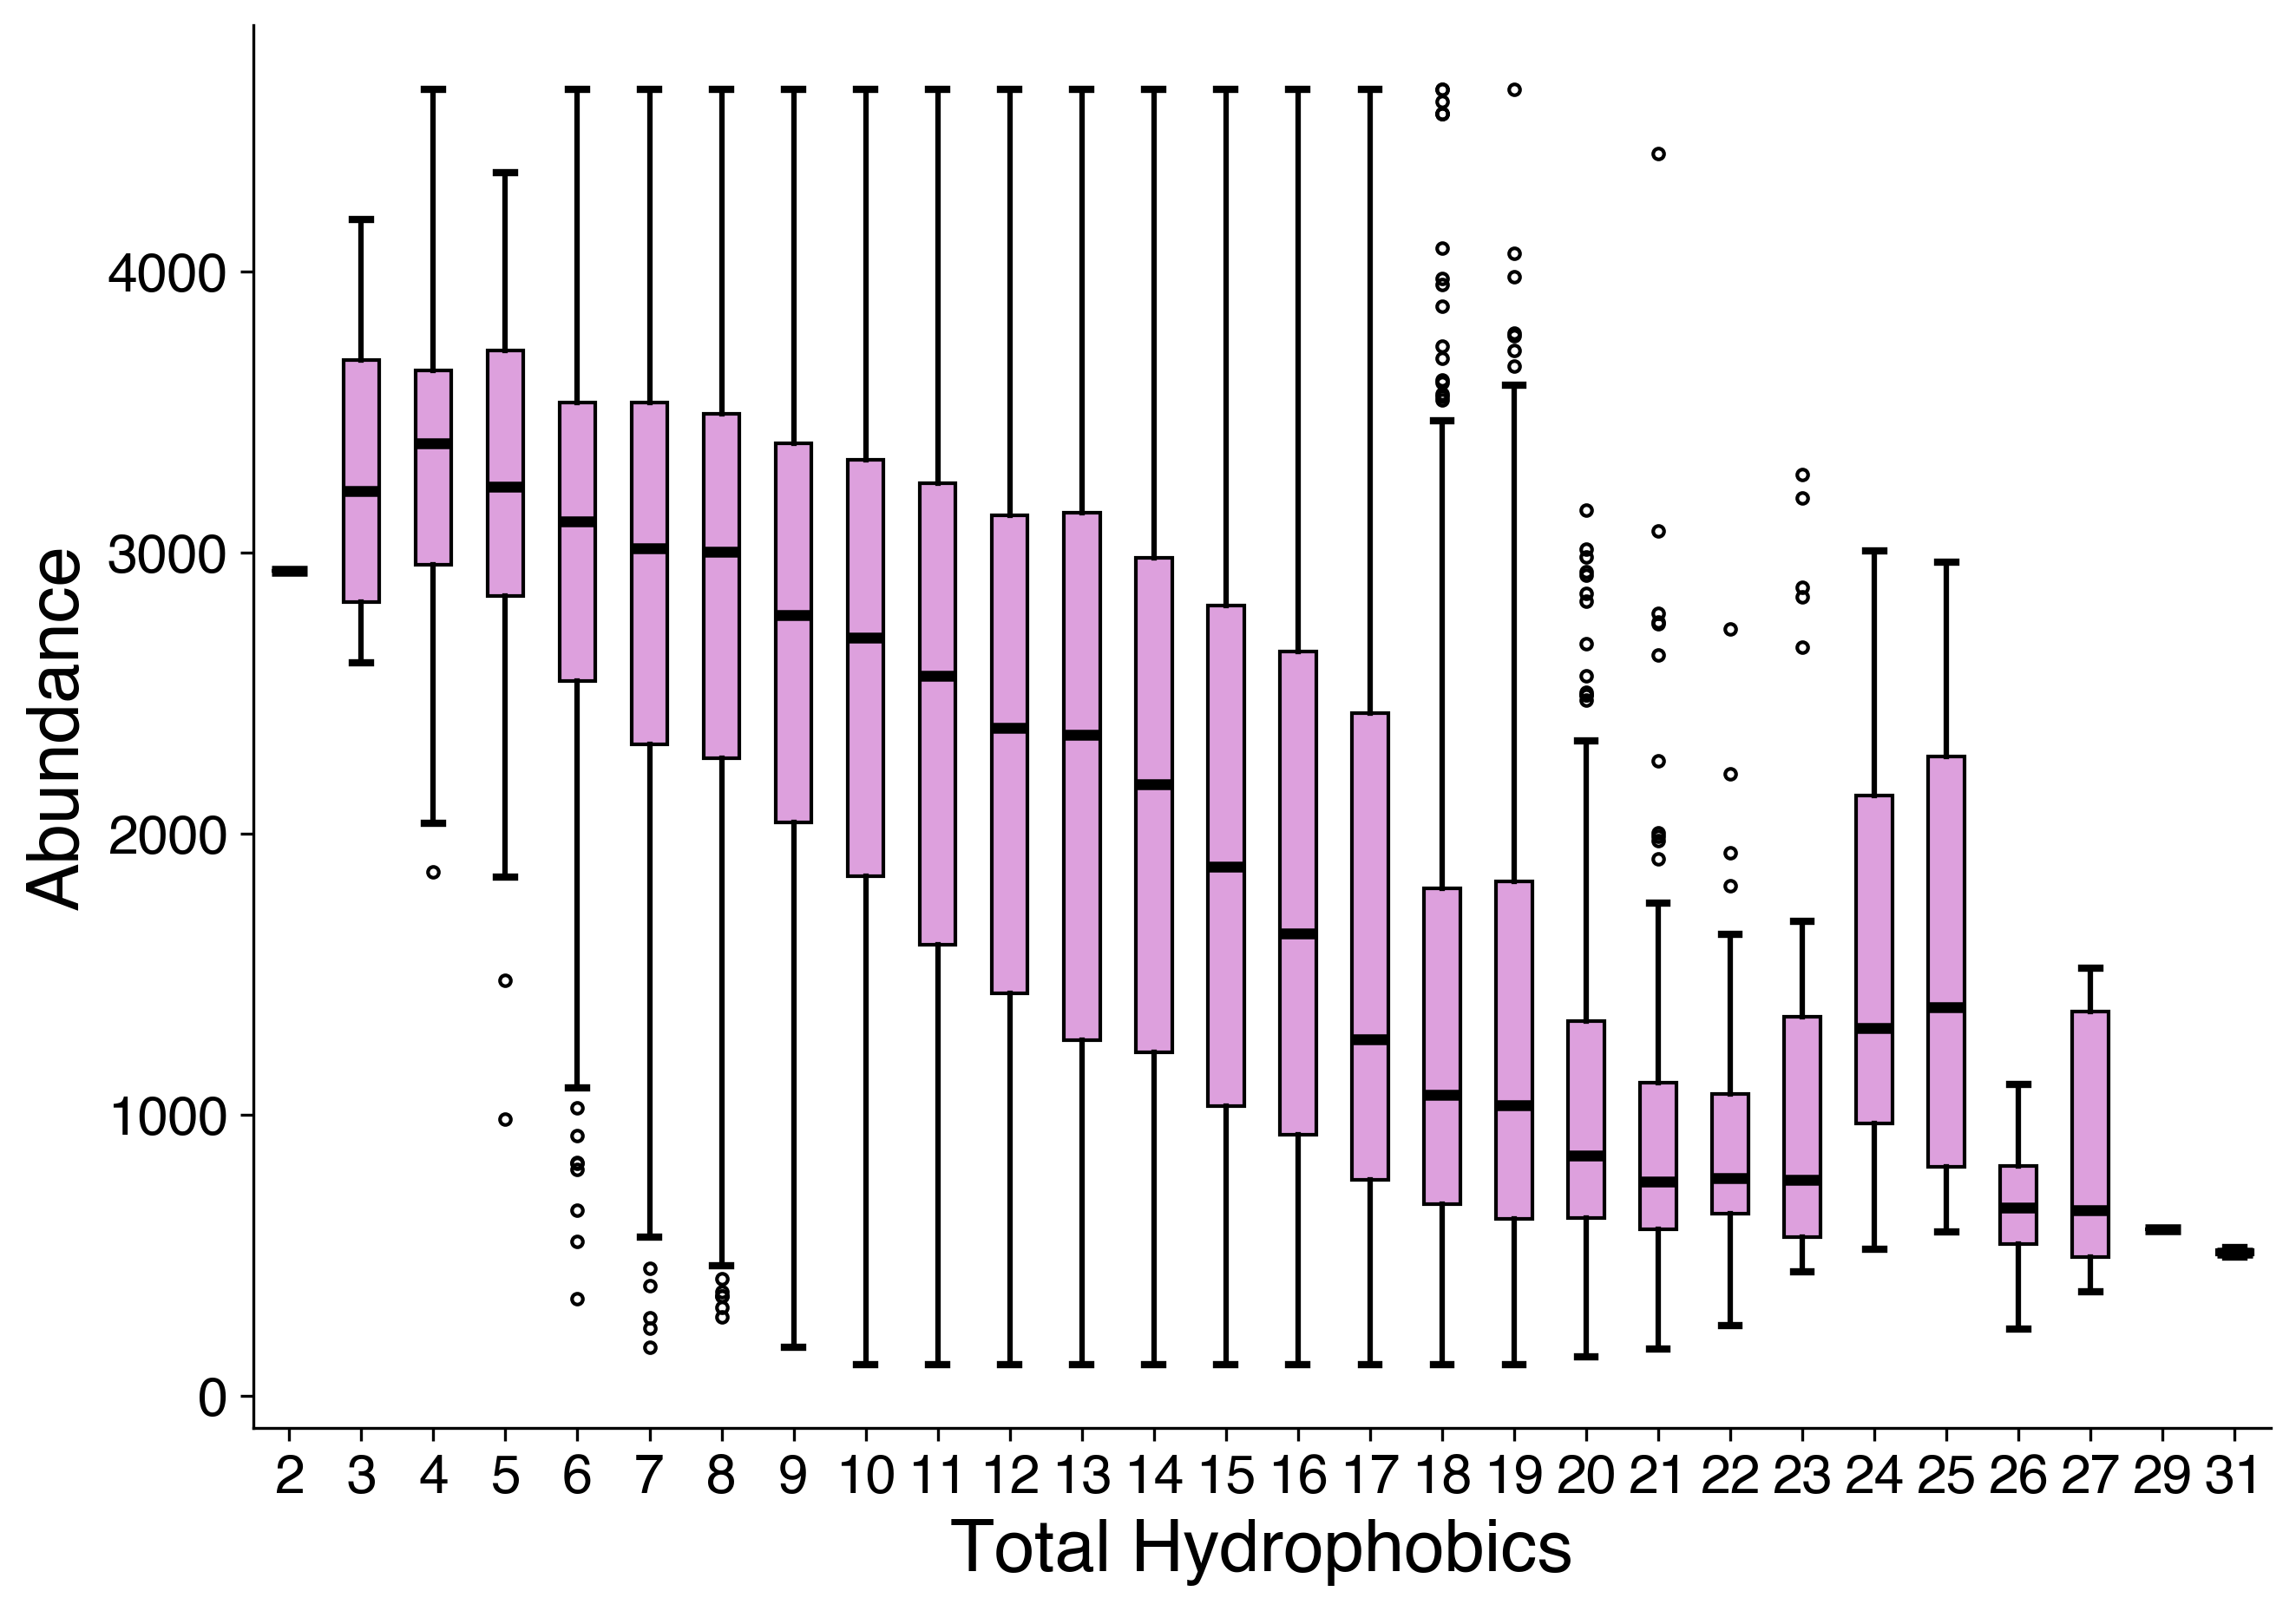

In [ ]:
# Code to create a boxplot of total abundance per hydrophobic count 

grouped_data = [data[data["total_hydrophobics"] == charge]["abundance"] for charge in sorted(data["total_hydrophobics"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_hydrophobics"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_hydrophobics"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("plum")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Hydrophobics", fontsize=20)
ax.set_ylabel("Abundance", fontsize=20)

ax.tick_params(labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_barplot_hydrophobic.pdf", format='pdf', bbox_inches='tight')


/var/folders/34/1pw3__x51kdfyh3vk72f5vc80000gn/T/ipykernel_31331/953215411.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grouped_data, labels=sorted(data["total_aromatics"].unique()), patch_artist=True)


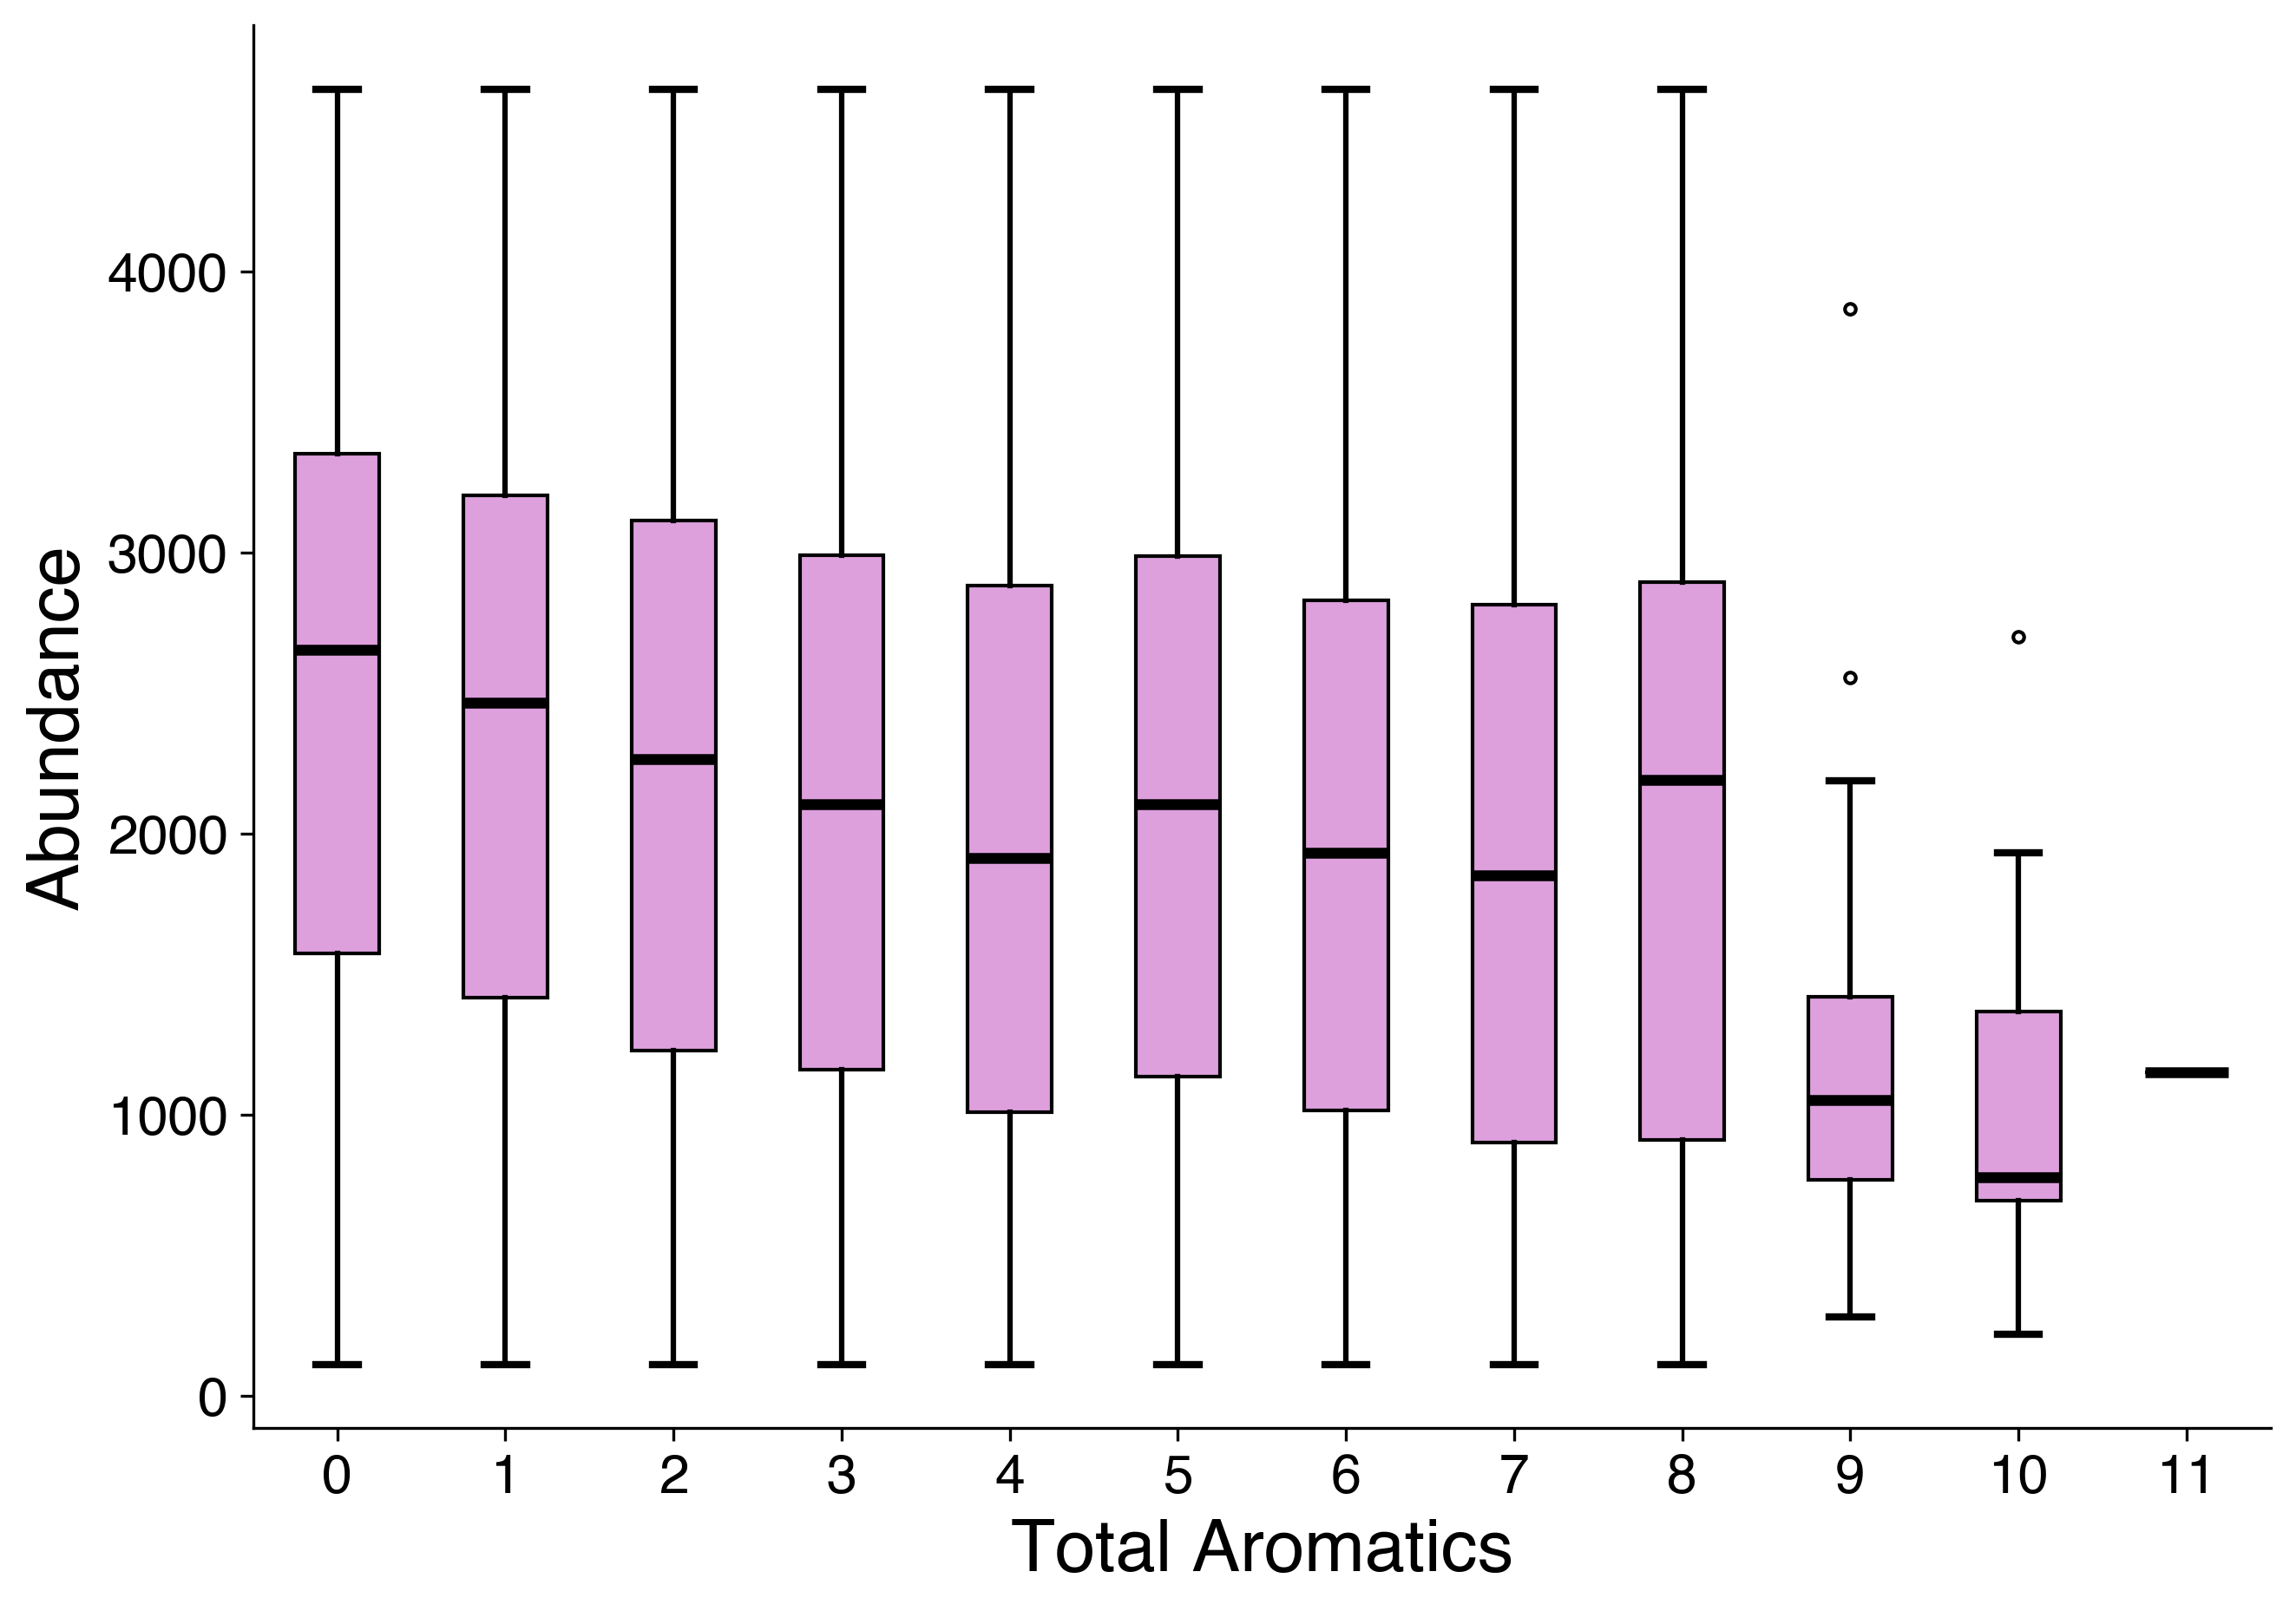

In [ ]:
# Code to create a boxplot of total abundance per aromatic count 

grouped_data = [data[data["total_aromatics"] == charge]["abundance"] for charge in sorted(data["total_aromatics"].unique())]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)

bp = ax.boxplot(grouped_data, labels=sorted(data["total_aromatics"].unique()), patch_artist=True)

for whisker in bp['whiskers']:
    whisker.set(linewidth = 1.5)

for cap in bp['caps']:
    cap.set(linewidth = 2)

for median in bp['medians']:
    median.set(color ='black',
               linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='.',
              color ='#e7298a')


# Generate colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(data["total_aromatics"].unique())))  # Use 'viridis' or try 'coolwarm', 'plasma', etc.

# Apply colors to each box
for patch in bp['boxes']:
    patch.set_facecolor("plum")
    patch.set_edgecolor("black")  # Add a dark outline for contrast

ax.set_xlabel("Total Aromatics", fontsize=20)
ax.set_ylabel("Abundance", fontsize=20)

ax.tick_params(labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.savefig("figures/abundance_barplot_hydrophobic.pdf", format='pdf', bbox_inches='tight')


In [66]:
data[["ends_w_two_hydrophobic", "contains_two_hydrophobic"]].value_counts()

ends_w_two_hydrophobic  contains_two_hydrophobic
False                   True                        15534
True                    True                         1898
False                   False                         300
Name: count, dtype: int64

In [ ]:
# Testing for statistical difference between ending w charge vs. hydrophobic
stat, p = mannwhitneyu(data[data["ends_w_charge"]]["abundance"], data[data["ends_w_hydrophobic"]]["abundance"], alternative='greater')
p

2.036630455681518e-110

In [ ]:
# Testing for statistical difference between ending w hydrophobic vs. overall distribution
stat, p = mannwhitneyu(data["abundance"], data[data["ends_w_hydrophobic"]]["abundance"], alternative='greater')
p

5.0541003890837723e-39

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


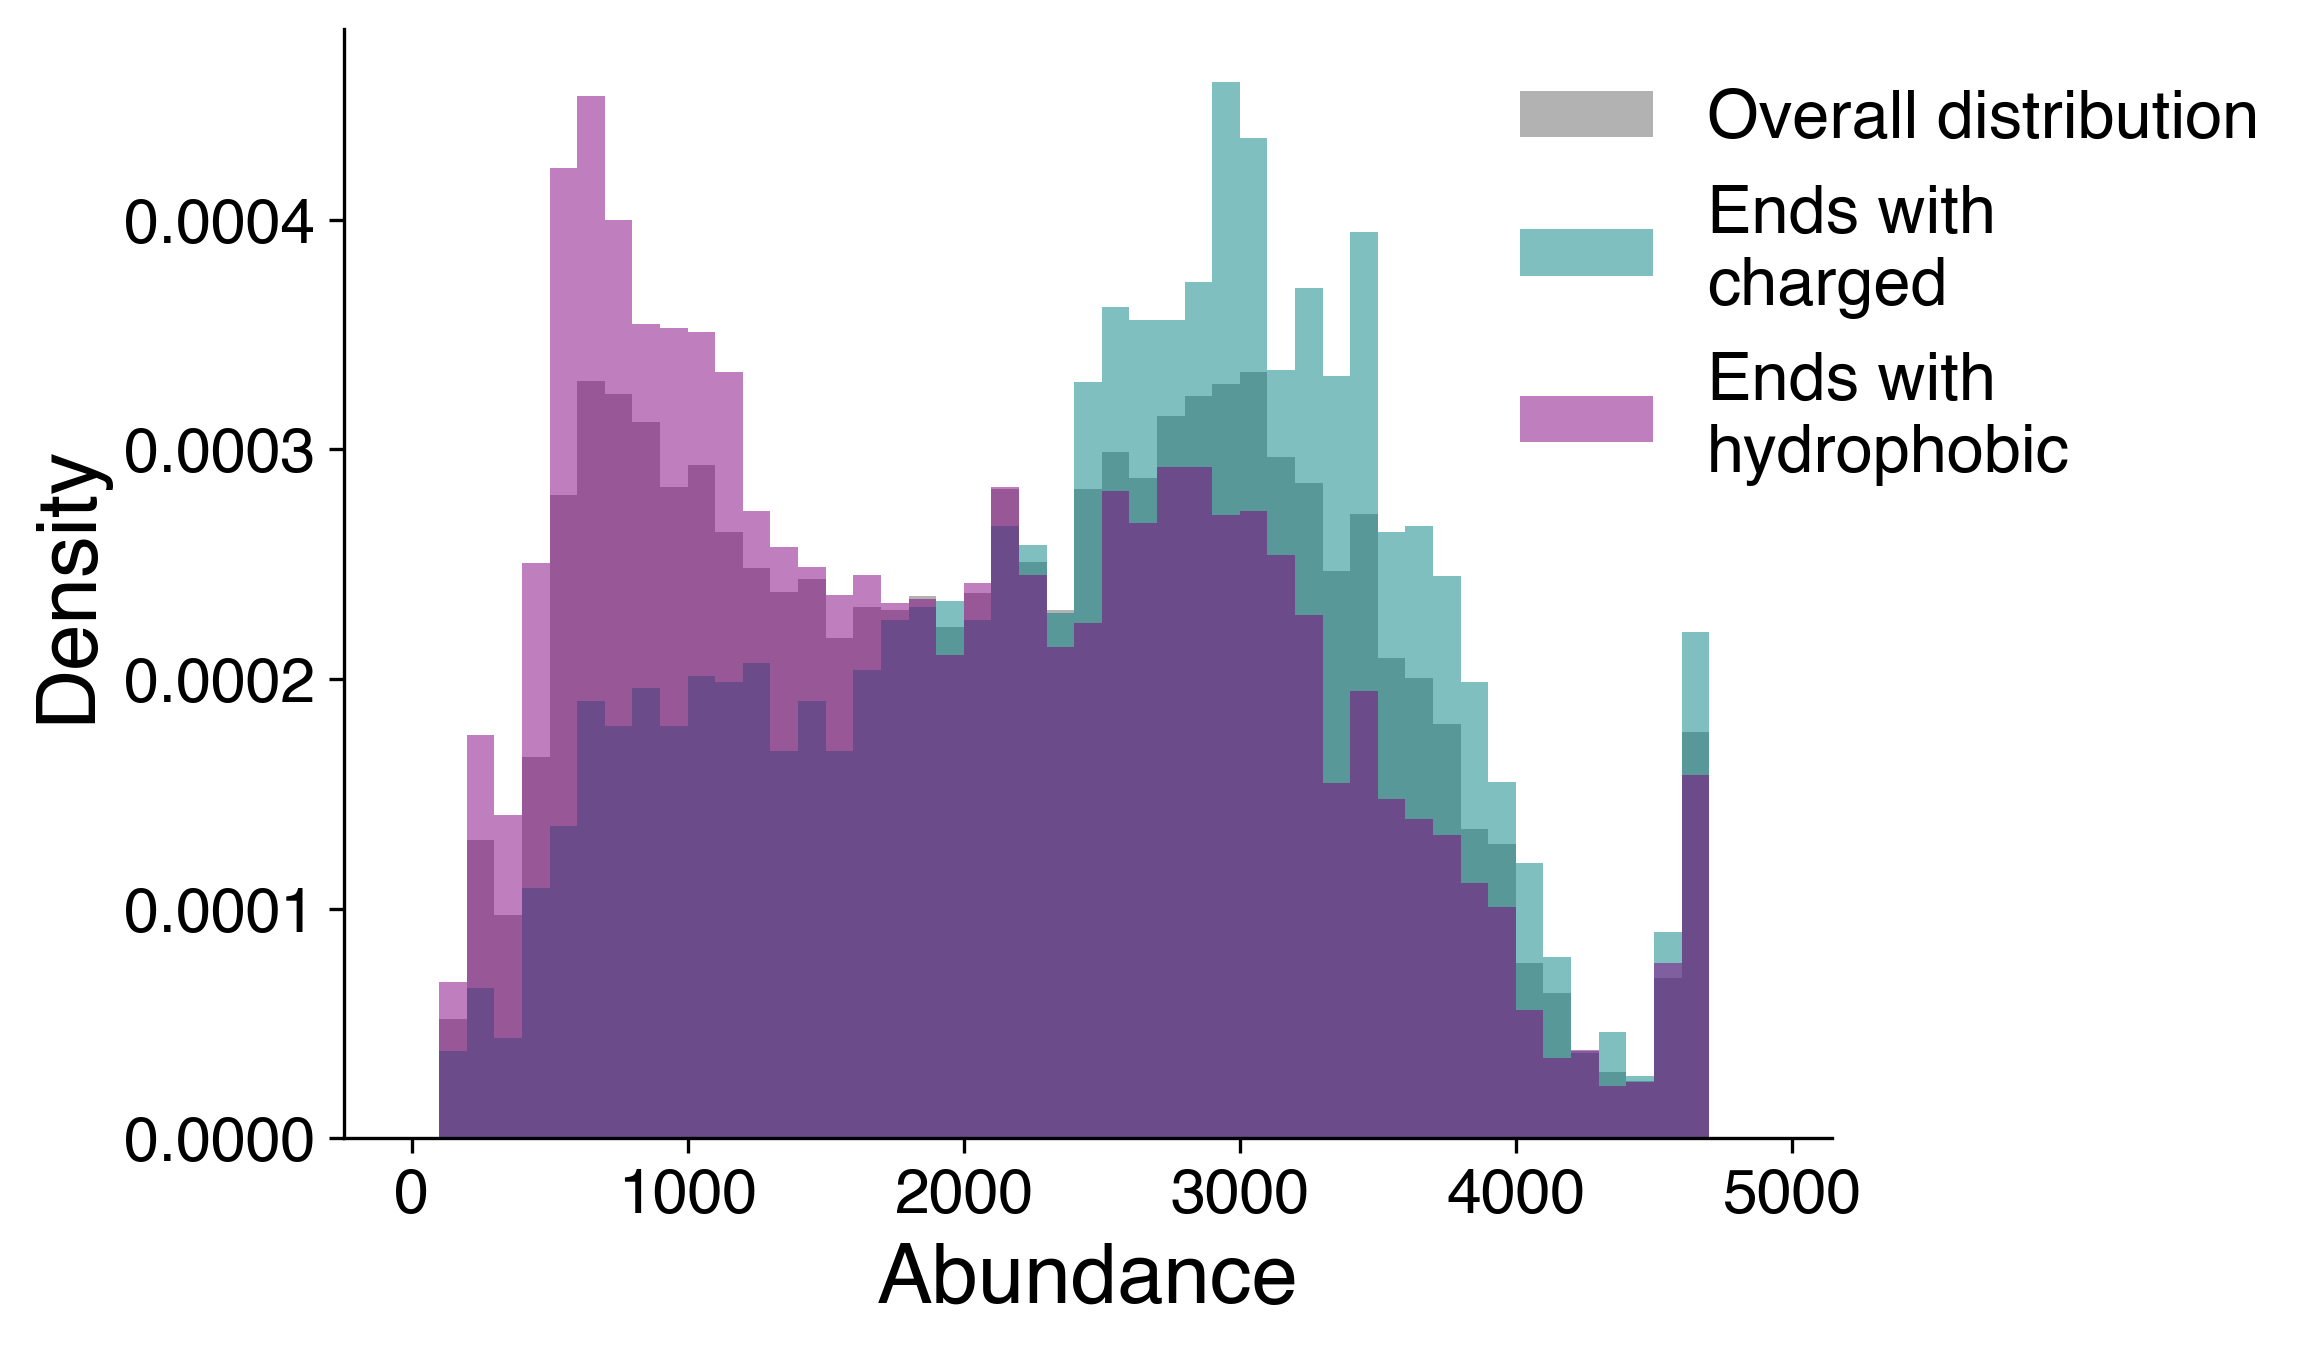

In [ ]:
# Plotting distribution differences between charged vs. hydrophobic ends

bins = np.arange(0, 5000, 100)
plt.hist(data["abundance"], density=True, alpha=0.3, bins=bins, color="black", label="Overall distribution")

plt.hist(data[data["ends_w_charge"]]["abundance"], density=True, alpha=0.5, bins=bins, color="teal", label="Ends with \ncharged")
plt.hist(data[data["ends_w_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="purple", label="Ends with \nhydrophobic")
plt.xlabel("Abundance", fontsize=20)
plt.xticks(size=15)
plt.ylabel("Density", fontsize=20)
plt.yticks(size=15)
plt.legend(fontsize=16, frameon=False, bbox_to_anchor=(0.75,1))

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_histograms.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


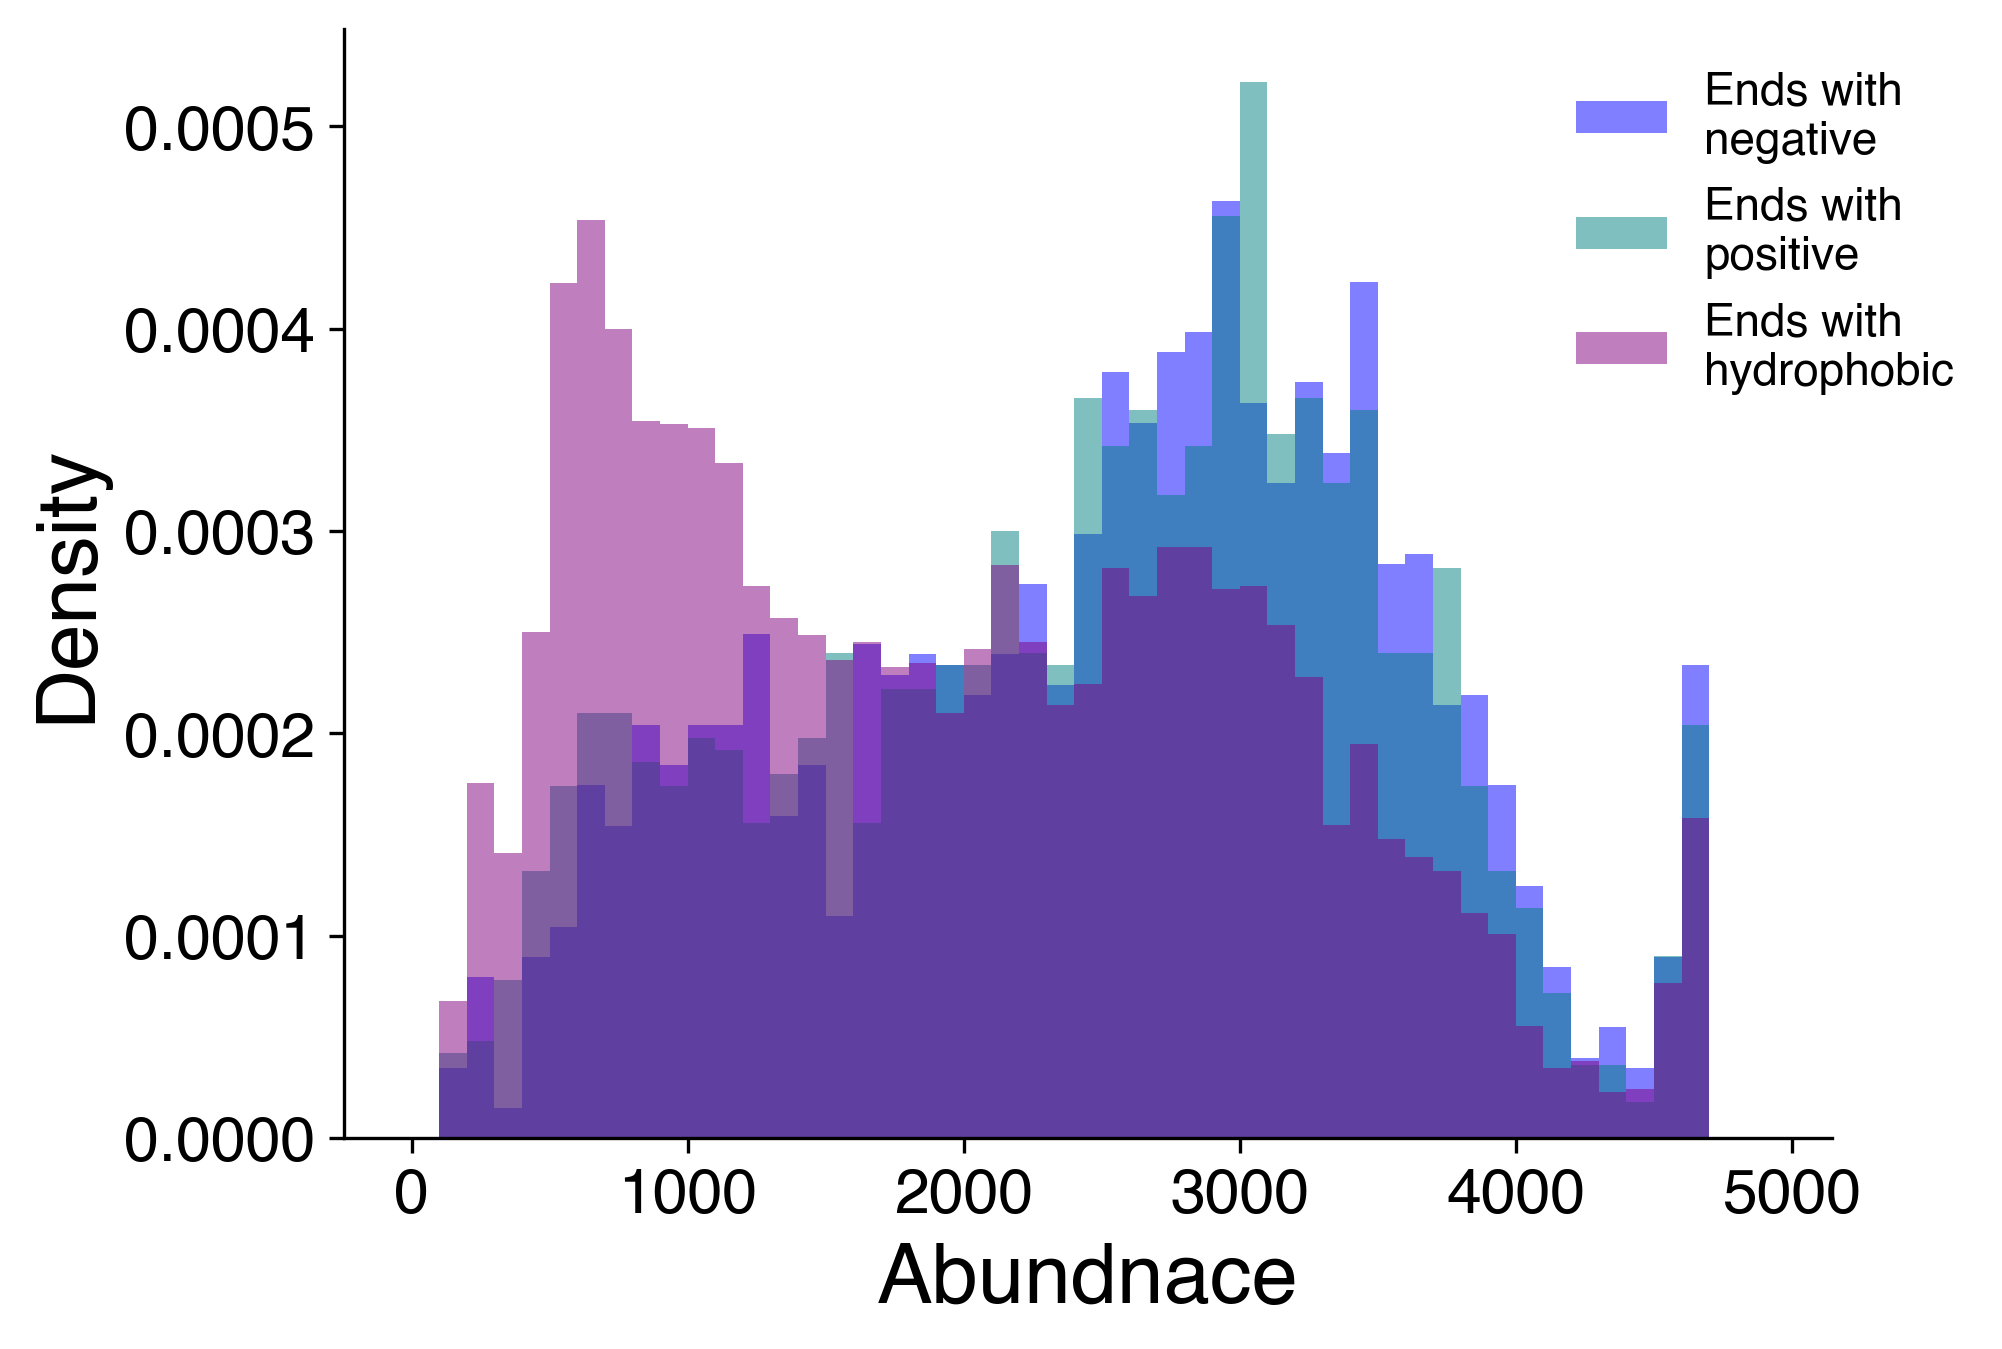

In [ ]:
# Plotting distribution differences between ending w/ positive, negative, or hydrophobic

bins = np.arange(0, 5000, 100)

plt.hist(data[data["ends_w_negative"]]["abundance"], density=True, alpha=0.5, bins=bins, color="blue", label="Ends with \nnegative")
plt.hist(data[data["ends_w_positive"]]["abundance"], density=True, alpha=0.5, bins=bins, color="teal", label="Ends with \npositive")
plt.hist(data[data["ends_w_hydrophobic"]]["abundance"], density=True, alpha=0.5, bins=bins, color="purple", label="Ends with \nhydrophobic")
plt.xlabel("Abundnace", fontsize=20)
plt.xticks(size=15)
plt.ylabel("Density", fontsize=20)
plt.yticks(size=15)
plt.legend(fontsize=11, bbox_to_anchor=(0.8,1), frameon=False)

ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig("figures/abundance_histograms_pos_negative.pdf", format='pdf', bbox_inches='tight')


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


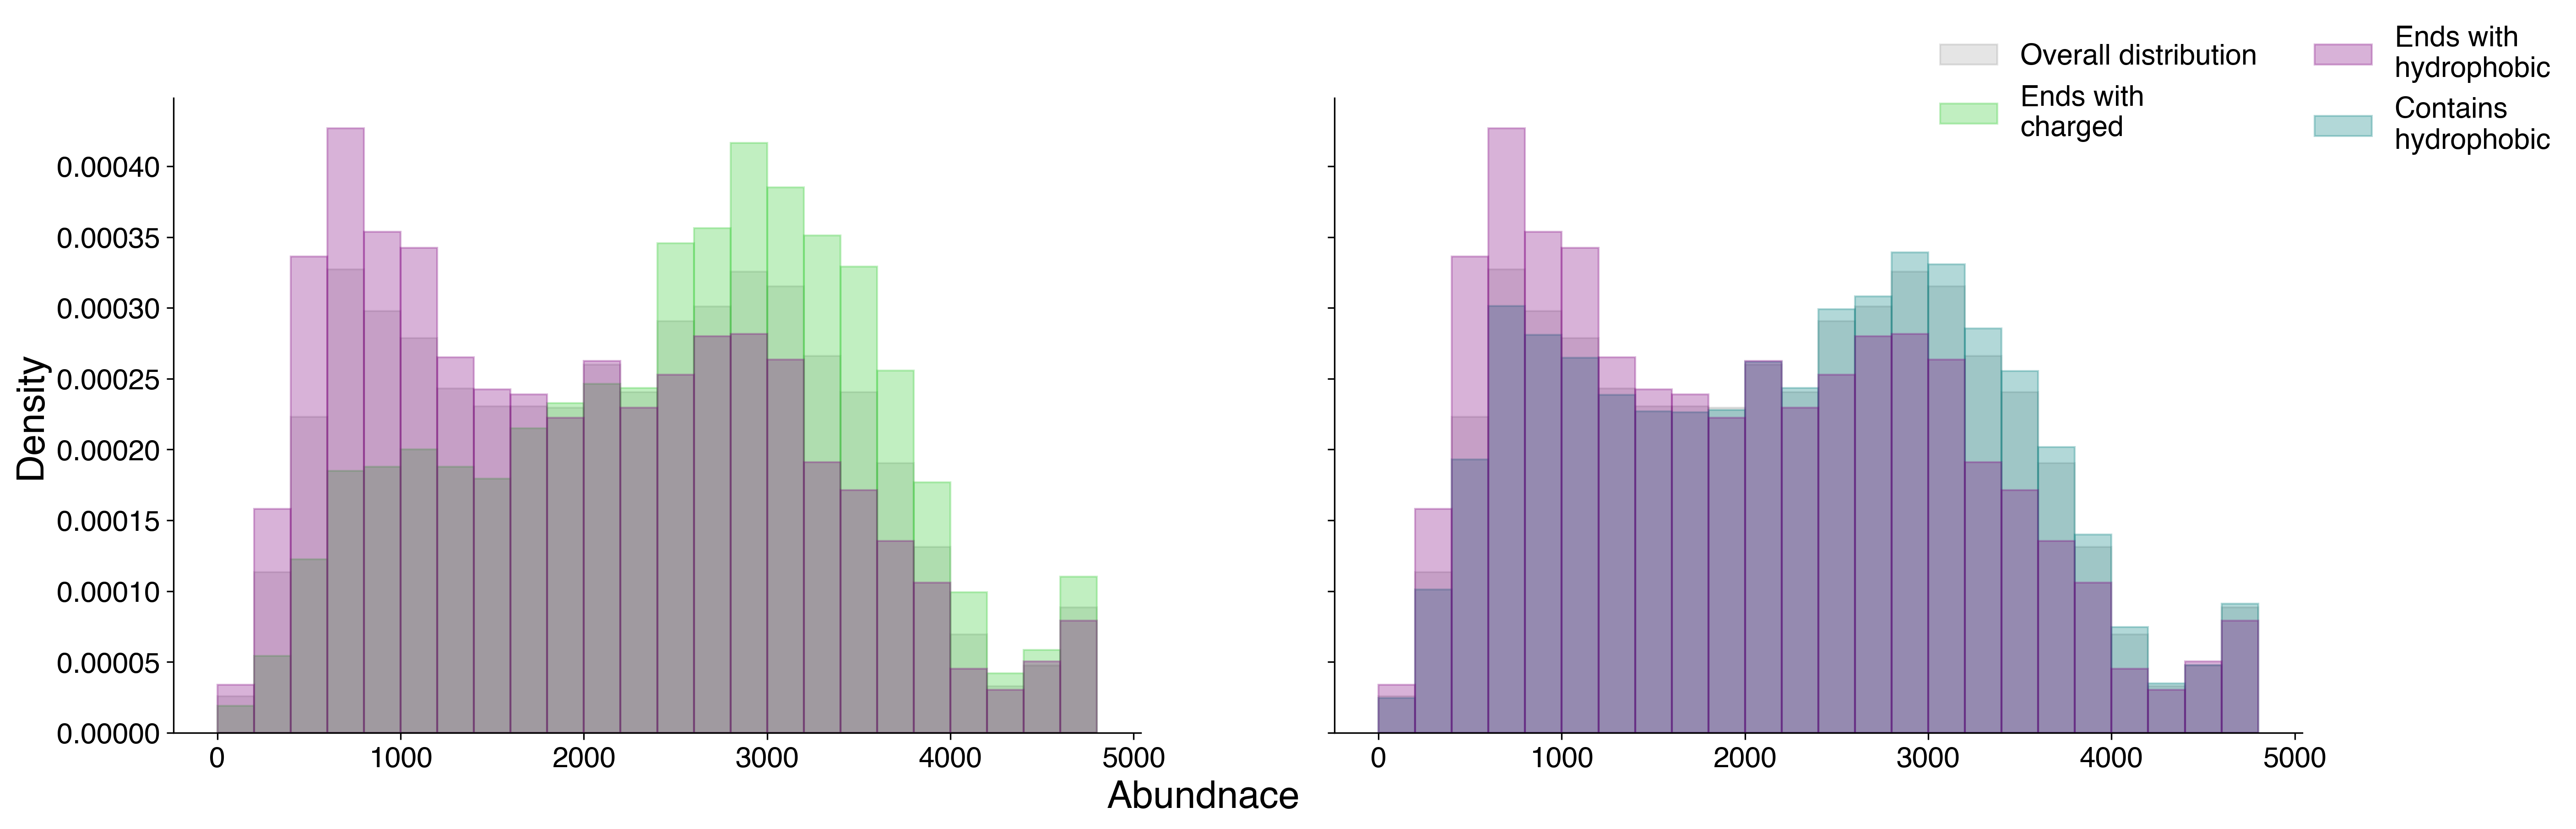

In [ ]:
# Plotting distribution differences between ending with hydrophobic vs. charged vs. containing a hydrophobic
bins = np.arange(0, 5000, 200)

fig, axs = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)

axs[0].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[0].hist(data[data["ends_w_charge"]]["abundance"], density=True, alpha=0.3, bins=bins, color="limegreen", label="Ends with \ncharged",edgecolor='limegreen')
axs[0].hist(data[data["ends_w_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \nhydrophobic",edgecolor='purple')

axs[1].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[1].hist(data[data["contains_hydrophobic"] & ~data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="teal", label="Contains \nhydrophobic",edgecolor='teal')
axs[1].hist(data[data["ends_w_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \nhydrophobic",edgecolor='purple')



fig.supxlabel("Abundnace", fontsize=20)
axs[0].tick_params(labelsize=15)
axs[1].tick_params(labelsize=15)
axs[0].set_ylabel("Density", fontsize=20)
plt.yticks(size=15)
# axs[0].legend(fontsize=15)
# axs[1].legend(fontsize=15)
# Collect all handles and labels from both axes
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()

# Combine and remove duplicates (optional)
handles = handles0 + handles1
labels = labels0 + labels1

# Remove duplicates while preserving order
seen = set()
unique = [(h, l) for h, l in zip(handles, labels) if l not in seen and not seen.add(l)]

# Create shared legend
fig.legend(*zip(*unique), loc='upper right', fontsize=15, ncol=2, frameon=False)

sns.despine()

plt.savefig("figures/abundance_histogram_one_hydrophobic.pdf", format='pdf', bbox_inches='tight')
plt.savefig("figures/abundance_histogram_one_hydrophobic.png", format='png', bbox_inches='tight')


In [ ]:
# Testing for statistical difference between ending w hydrophobic vs. containing a hydrophobic anywhere
stat, p = mannwhitneyu(data[data["contains_hydrophobic"]]["abundance"], data[data["ends_w_hydrophobic"]]["abundance"], alternative='greater')
p

5.0541003890837723e-39

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


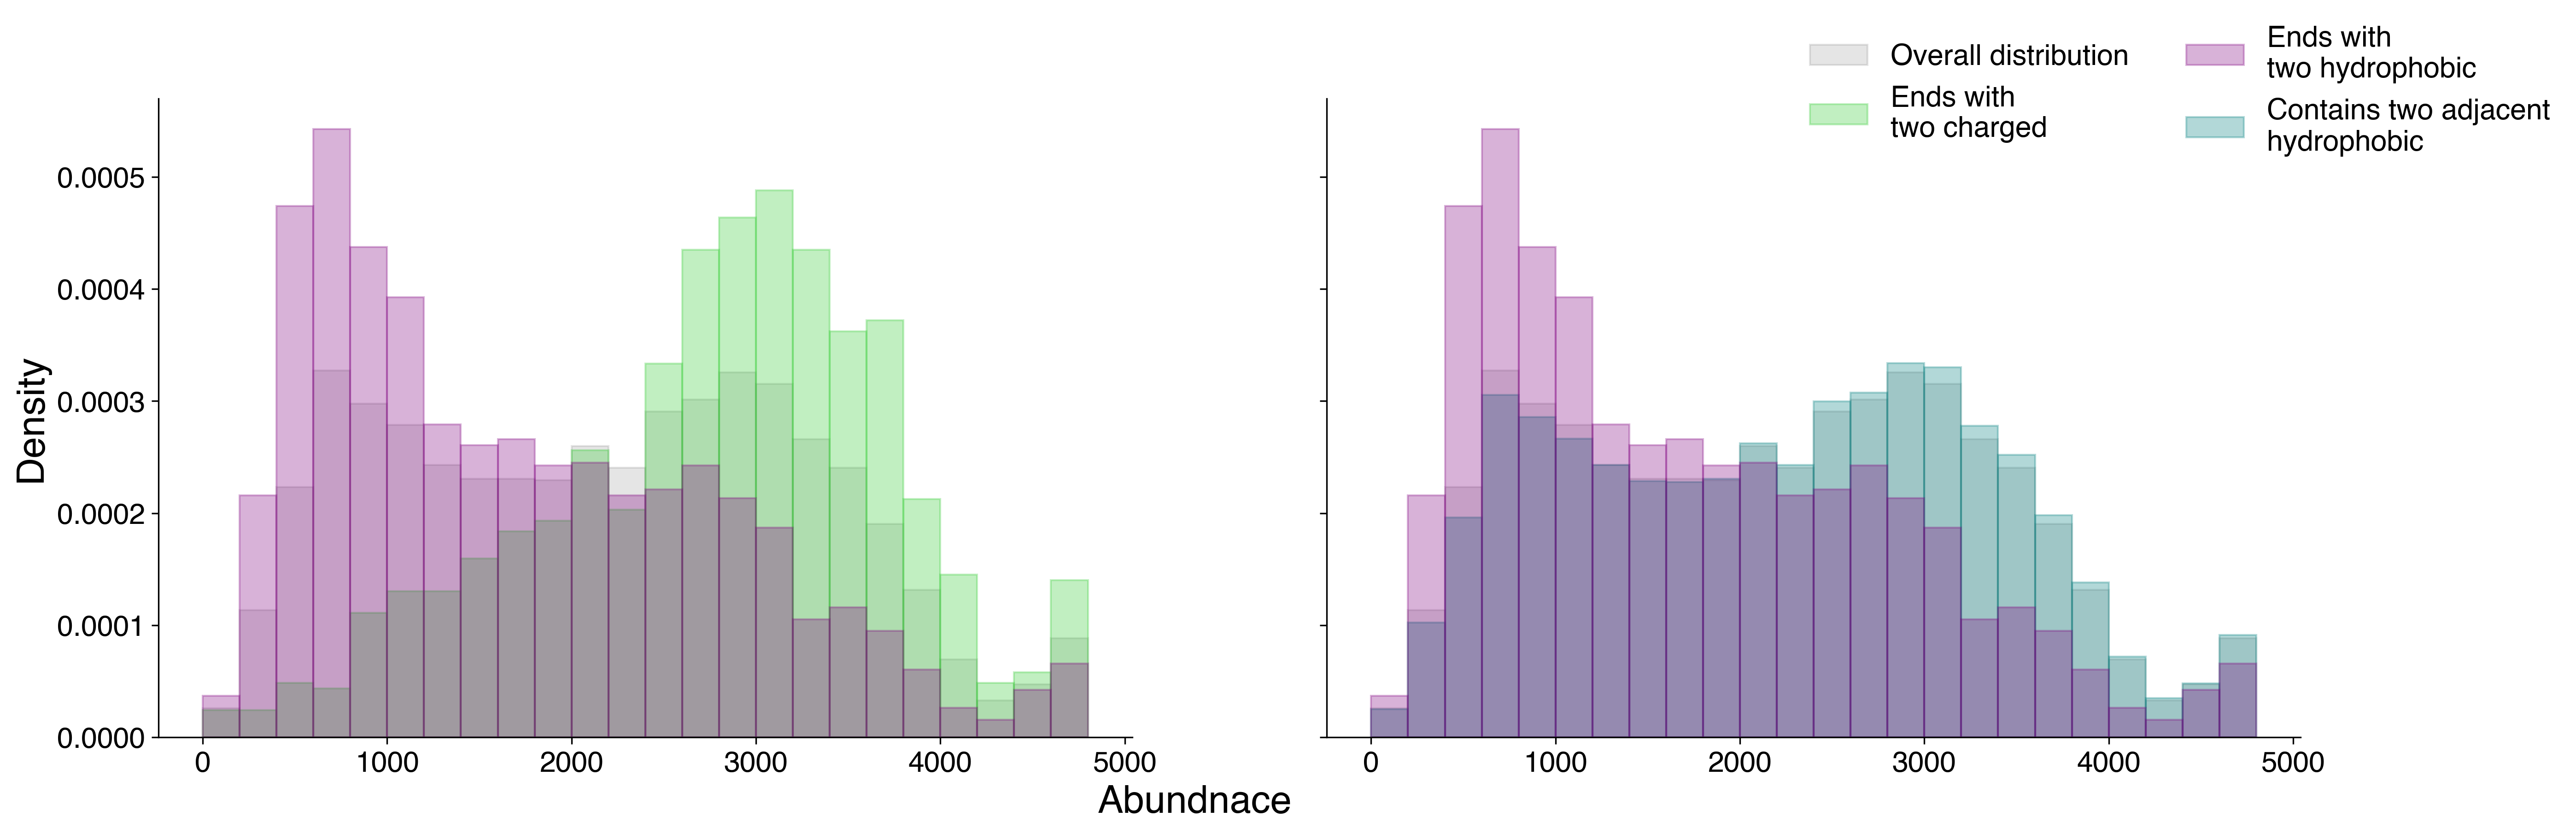

In [ ]:
# Plotting distribution differences between ending with 2+ hydrophobic vs. 2+ charged vs. containing 2+ hydrophobic
bins = np.arange(0, 5000, 200)

fig, axs = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)

axs[0].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[0].hist(data[data["ends_w_two_charge"]]["abundance"], density=True, alpha=0.3, bins=bins, color="limegreen", label="Ends with \ntwo charged",edgecolor='limegreen')
axs[0].hist(data[data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \ntwo hydrophobic",edgecolor='purple')

axs[1].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[1].hist(data[data["contains_two_hydrophobic"] & ~data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="teal", label="Contains two adjacent\nhydrophobic",edgecolor='teal')
axs[1].hist(data[data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \ntwo hydrophobic",edgecolor='purple')



fig.supxlabel("Abundnace", fontsize=20)
axs[0].tick_params(labelsize=15)
axs[1].tick_params(labelsize=15)
axs[0].set_ylabel("Density", fontsize=20)
plt.yticks(size=15)
# axs[0].legend(fontsize=15)
# axs[1].legend(fontsize=15)
# Collect all handles and labels from both axes
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()

# Combine and remove duplicates (optional)
handles = handles0 + handles1
labels = labels0 + labels1

# Remove duplicates while preserving order
seen = set()
unique = [(h, l) for h, l in zip(handles, labels) if l not in seen and not seen.add(l)]

# Create shared legend
fig.legend(*zip(*unique), loc='upper right', fontsize=15, ncol=2, frameon=False)

sns.despine()

plt.savefig("figures/abundance_histogram_two_hydrophobic.pdf", format='pdf', bbox_inches='tight')
plt.savefig("figures/abundance_histogram_two_hydrophobic.png", format='png', bbox_inches='tight')


In [ ]:
# Testing for statistical difference between ending w 2+ hydrophobic vs. containing 2+ hydrophobic anywhere

stat, p = mannwhitneyu(data[data["contains_two_hydrophobic"]]["abundance"], data[data["ends_w_two_hydrophobic"]]["abundance"], alternative='greater')
p

8.624320879581119e-70

In [ ]:
# Testing for statistical difference between ending w 2+ hydrophobic vs. ending w 2+ charge
stat, p = mannwhitneyu(data[data["ends_w_two_charge"]]["abundance"], data[data["ends_w_two_hydrophobic"]]["abundance"], alternative='greater')
p

8.545606479465964e-129

In [ ]:
# Testing for statistical difference between ending w 2+ hydrophobic vs. overall distribution
stat, p = mannwhitneyu(data["abundance"], data[data["contains_two_hydrophobic"]]["abundance"], alternative='greater')
p

0.155353658323451

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


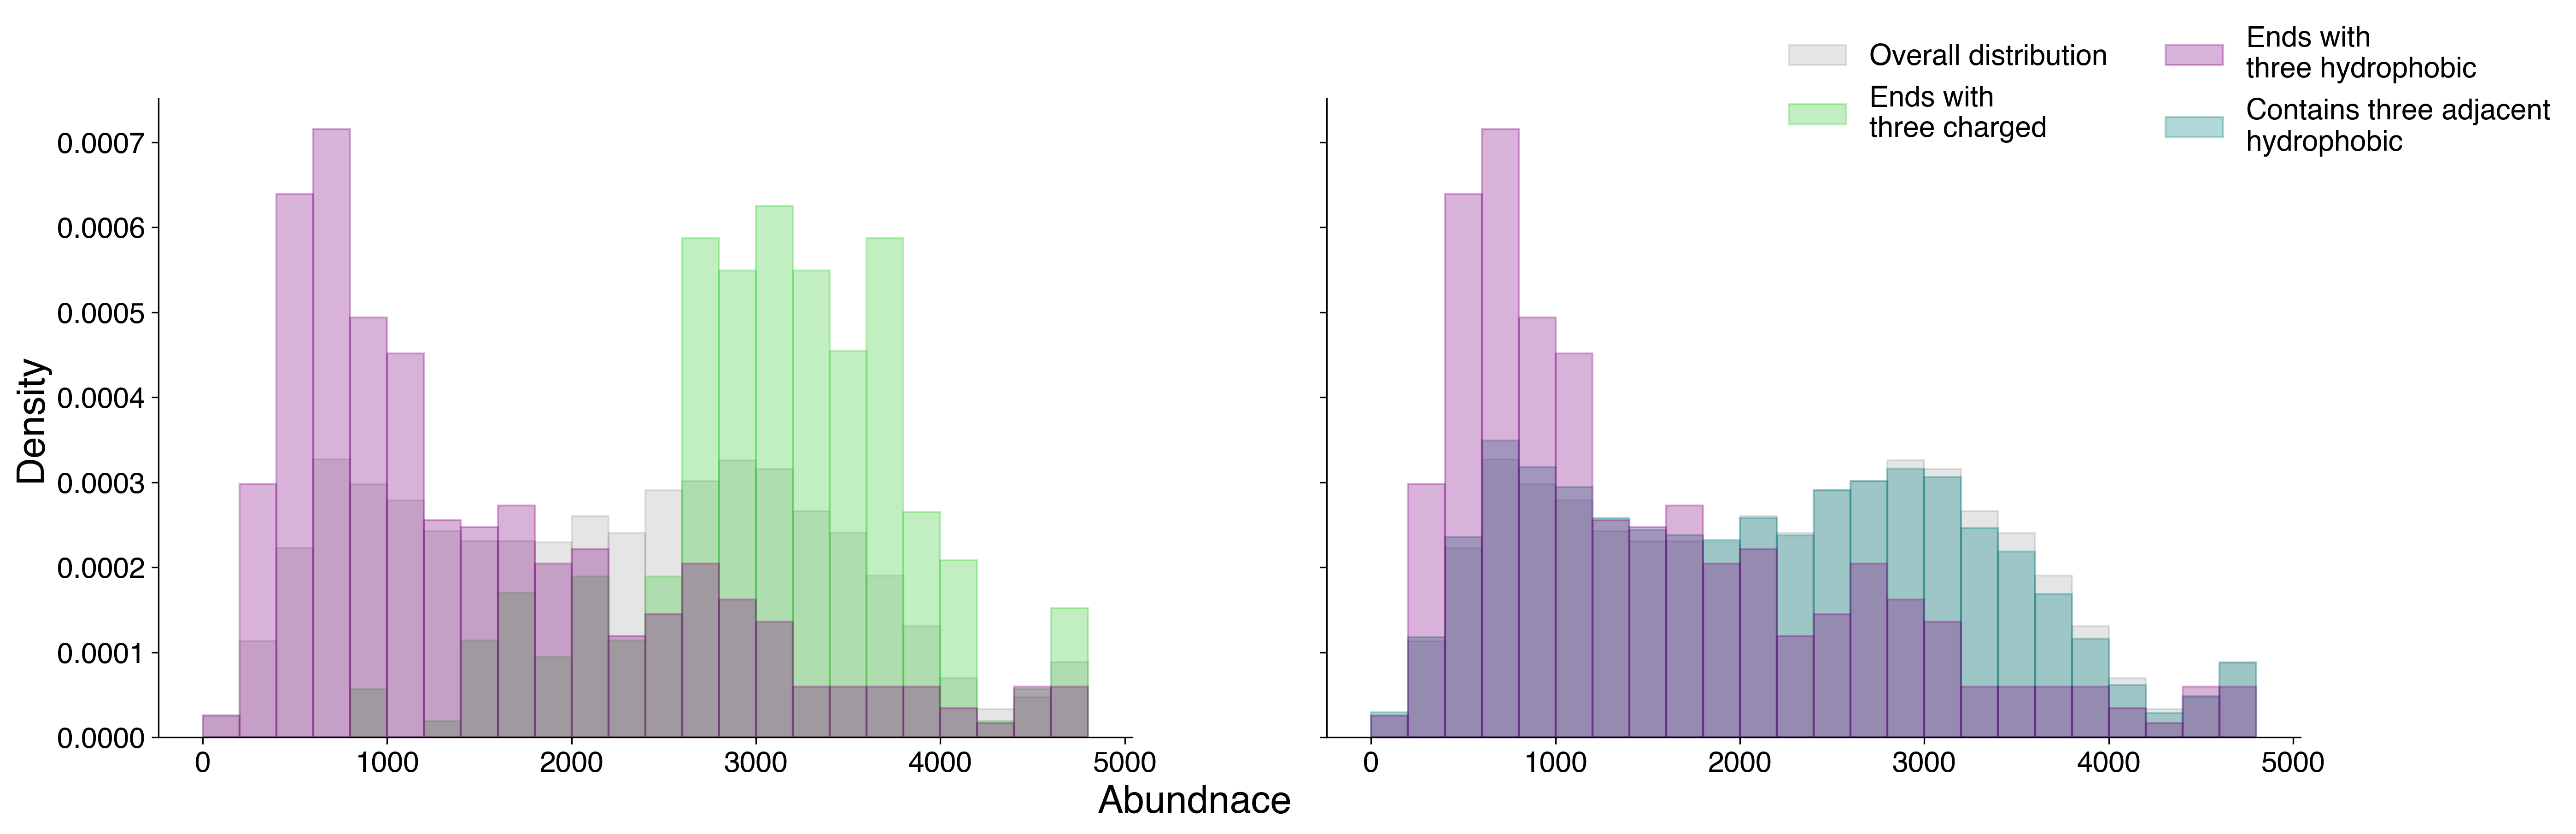

In [ ]:
# Plotting distribution differences between ending with 3+ hydrophobic vs. 3+ charged vs. containing 3+ hydrophobic

bins = np.arange(0, 5000, 200)

fig, axs = plt.subplots(1,2, figsize=(20,6), sharex=True, sharey=True)

axs[0].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[0].hist(data[data["ends_w_three_charge"]]["abundance"], density=True, alpha=0.3, bins=bins, color="limegreen", label="Ends with \nthree charged",edgecolor='limegreen')
axs[0].hist(data[data["ends_w_three_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \nthree hydrophobic",edgecolor='purple')

axs[1].hist(data["abundance"], density=True, alpha=0.1, bins=bins, color="black", label="Overall distribution",edgecolor='black')
axs[1].hist(data[data["contains_three_hydrophobic"] & ~data["ends_w_two_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="teal", label="Contains three adjacent\nhydrophobic",edgecolor='teal')
axs[1].hist(data[data["ends_w_three_hydrophobic"]]["abundance"], density=True, alpha=0.3, bins=bins, color="purple", label="Ends with \nthree hydrophobic",edgecolor='purple')



fig.supxlabel("Abundnace", fontsize=20)
axs[0].tick_params(labelsize=15)
axs[1].tick_params(labelsize=15)
axs[0].set_ylabel("Density", fontsize=20)
plt.yticks(size=15)
# axs[0].legend(fontsize=15)
# axs[1].legend(fontsize=15)
# Collect all handles and labels from both axes
handles0, labels0 = axs[0].get_legend_handles_labels()
handles1, labels1 = axs[1].get_legend_handles_labels()

# Combine and remove duplicates (optional)
handles = handles0 + handles1
labels = labels0 + labels1

# Remove duplicates while preserving order
seen = set()
unique = [(h, l) for h, l in zip(handles, labels) if l not in seen and not seen.add(l)]

# Create shared legend
fig.legend(*zip(*unique), loc='upper right', fontsize=15, ncol=2, frameon=False)

sns.despine()

plt.savefig("figures/abundance_histogram_three_hydrophobic.pdf", format='pdf', bbox_inches='tight')
plt.savefig("figures/abundance_histogram_three_hydrophobic.png", format='png', bbox_inches='tight')


In [ ]:
# Testing for statistical difference between ending w 3+ hydrophobic vs. containing 3+ hydrophobic anywhere

stat, p = mannwhitneyu(data[data["contains_three_hydrophobic"]]["abundance"], data[data["ends_w_three_hydrophobic"]]["abundance"], alternative='greater')
p

1.3814101189241854e-35

In [ ]:
# Testing for statistical difference between ending w 3+ hydrophobic vs. ending w 3+ charge
stat, p = mannwhitneyu(data[data["ends_w_three_charge"]]["abundance"], data[data["ends_w_three_hydrophobic"]]["abundance"], alternative='greater')
p

1.1528338232149514e-68

In [ ]:
# Testing for statistical difference between ending w 3+ hydrophobic vs. overall distribution
stat, p = mannwhitneyu(data["abundance"], data[data["contains_three_hydrophobic"]]["abundance"], alternative='greater')
p

1.3935806563918882e-21